# Frame the Problem

1. **What is the objective?**  
   To understand and quantify the causal relationship between air quality and health outcomes. It is well established that deteriorating air quality can exacerbate conditions such as asthma and heart disease. For point-in-time events (e.g., forest fires, storms) that cause rapid declines in air quality, can we quantify their causal impact on health outcomes? For example, how many incremental emergency room visits for asthma attacks or heart attacks can be causally linked to the LA fires of early 2025?

2. **How will the solution be used?**  
   For now, this will be a standalone data analysis. In theory, cities could use insights from such an analysis to better prepare for spikes in emergency room visits during and after air quality events like fires or storms. Additionally, as the frequency and severity of these events increase due to climate change, this analysis could help forecast the public health costs of inaction on climate issues.

3. **What are current solutions?**  
   A brief search reveals a few similar analyses using machine learning to predict hospital visit volumes based on environmental data such as air quality:

   - [**Predictive Analytics for Emergency Department Visits Based on Local Short-Term Pollution and Weather Exposure**](https://www.researchgate.net/publication/379227522_Predictive_analytics_for_Emergency_Department_visits_based_on_local_short-term_pollution_and_weather_exposure):  
     This study applies machine learning techniques to forecast daily emergency department (ED) visits and hospitalizations for cardiovascular and respiratory conditions in Brescia, Italy (2018–2022). The researchers used Random Forest and ARIMA models, incorporating local air pollution and weather data. They found that the Random Forest model more accurately captured overall trends compared to ARIMA. The findings suggest that integrating environmental data with machine learning can improve ED resource planning and patient care during environmental events.

   - [**Peak Outpatient and Emergency Department Visit Forecasting for Patients With Chronic Respiratory Diseases Using Machine Learning Methods: Retrospective Cohort Study**](https://medinform.jmir.org/2020/3/e13075/?utm_source=chatgpt.com):  
     This retrospective study evaluates machine learning models for predicting peak outpatient and emergency department (OED) visits among patients with chronic respiratory diseases. The models combined air quality and weather data, using methods such as adaptive boosting-based neural networks, tree bagging, and random forests. The Random Forest model achieved the highest performance, with an AUC of 0.809. The study concludes that such models can effectively anticipate patient surges, aiding in proactive medical resource allocation.

4. **How should the problem be framed?**  
   This is primarily a regression task, using ML methods to predict continuous outcomes. The causal analysis is an extension of this task. I plan to use a geo experiment or matched-market framework to estimate causal impact via a counterfactual approach. The accuracy of the causal estimates hinges on the quality of the counterfactual.

5. **How should performance be measured?**  
   In geo experiments, performance is typically evaluated using Minimum Detectable Effect (MDE) and statistical power:

   - **MDE:** The smallest effect size the experiment can reliably detect. A smaller MDE implies greater sensitivity, enabling the detection of subtle effects. It is influenced by factors like KPI variability, the number of geographic units, and experiment duration.
   - **Power:** The probability of detecting a true effect when one exists. A standard threshold is 80%, meaning there is an 80% chance of identifying a real effect. Higher power reduces the risk of Type II errors.

6. **What are comparable problems?**  
   As mentioned, geo experiments are commonly used in marketing to estimate the incremental effect of ad spend on downstream outcomes (e.g., sales). While at Pinterest, I frequently analyzed geo experiment data. Several third-party vendors (e.g., Measured, Nielsen) offer geo experiment platforms, and companies like Google and Meta have released open-source tools, `matched_markets` and `GeoLift`, respectively.

7. **Have any assumptions been made?**  
   Yes. The analysis assumes that data on environmental factors (e.g., air quality, forest fires, storms) and health outcomes (e.g., hospital visits) is readily accessible. It also assumes that the geo experiment framework is applicable to this type of data.


# Get the Data

**What data is needed?**

This analysis requires several types of data:

1. **Environmental factors**,  including temperature, humidity, air quality, and related metrics.
   - I will use the EPA Air Quality System (AQS) to obtain this data. The AQS provides daily summary data on pollutants and meteorological conditions. This data is available through [pre-generated data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html) and a [REST API](https://aqs.epa.gov/aqsweb/documents/data_api.html). I will use the API, as it offers more flexibility and supports reproducible workflows.
2. **Health Outcomes**,  Specifically, hospital visits, with detailed information on the reasons for each visit.

   - As a starting point, I identified relevant health outcome data from the NYC Department of Health. In particular, the [NYC Syndromic Surveillance Data (SSD)](https://a816-health.nyc.gov/hdi/epiquery/visualizations?PageType=ps&PopulationSource=Syndromic) provides information on emergency department visits related to asthma, diarrhea, influenza-like illness, respiratory disease, and vomiting. This dataset is available daily from 2016 onward and can be disaggregated by age group and geographic region. It covers 100% of emergency department visits in NYC. 

   - It is important to note that the data reflects each patient's chief complaint at the time of the visit, rather than a confirmed diagnosis.

Ideally, the data should be as granular as possible, preferably at the daily level, since geo experiments rely on time series data.


## CBSA-level environmental data

In [1]:
# Get API key

import requests
from dotenv import load_dotenv
import os 

load_dotenv()

email = os.getenv("EMAIL")
url = "https://aqs.epa.gov/data/api/signup"
params = {
    "email": email
}

# response = requests.get(url, params=params)

# if response.status_code == 200:
#     print("Successfully signed up for the EPA AQS API.")
# else:   
#     print(f"Failed to sign up for the EPA AQS API. Status code: {response.status_code}")
#     print("Response:", response.text)

api_key = os.getenv("API_KEY")

In [2]:
# Parameter classes

import pandas as pd

url = "https://aqs.epa.gov/data/api/list/classes"
params = {
    "email": email, 
    "key": api_key
}

def get_aqs_data(url, params):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print("Successfully got data.")
        data = response.json()
        if data["Data"]:
            df = pd.DataFrame(data["Data"])
            return df
        else:
            print("No data returned for given parameters.")
    else:
        print(f"Failed to get data. Status code: {response.status_code}")
        print("Response:", response.text)

parameter_classes = get_aqs_data(url, params)
parameter_classes

Successfully got data.


,code,value_represented
0,AIRNOW MAPS,The parameters represented on AirNow maps (881...
1,ALL,Select all Parameters Available
2,AQI POLLUTANTS,Pollutants that have an AQI Defined
3,CORE_HAPS,Urban Air Toxic Pollutants
4,CRITERIA,Criteria Pollutants
5,CSN DART,List of CSN speciation parameters to populate ...
6,FORECAST,Parameters routinely extracted by AirNow (STI)
7,HAPS,Hazardous Air Pollutants
8,IMPROVE CARBON,IMPROVE Carbon Parameters
9,IMPROVE_SPECIATION,PM2.5 Speciated Parameters Measured at IMPROVE...


In [3]:
# Parameters by class 

url = "https://aqs.epa.gov/data/api/list/parametersByClass"
params = {
    "email": email, 
    "key": api_key, 
    "pc": "AIRNOW MAPS"
}

parameters_by_class = get_aqs_data(url, params)
parameters_by_class

Successfully got data.


,code,value_represented
0,44201,Ozone
1,88101,PM2.5 - Local Conditions
2,88502,Acceptable PM2.5 AQI & Speciation Mass


In [4]:
# CBSAs 

url = "https://aqs.epa.gov/data/api/list/cbsas"
params = {
    "email": email, 
    "key": api_key, 
}

cbsa = get_aqs_data(url, params)
cbsa.head()

Successfully got data.


,code,value_represented
0,10020,"Abbeville, LA"
1,10100,"Aberdeen, SD"
2,10140,"Aberdeen, WA"
3,10180,"Abilene, TX"
4,10220,"Ada, OK"


In [5]:
# Test, get AQI data for a single CBSA 
# CBSA: New York-Newark-Jersey City, NY-NJ-PA (Code 35620)

url = "https://aqs.epa.gov/data/api/dailyData/byCBSA"
params = {
    "email": email, 
    "key": api_key, 
    "param": "88101", 
    "bdate": "20230101", 
    "edate": "20231231", 
    "cbsa": "35620"
}

ny_daily_pm25 = get_aqs_data(url, params)
ny_daily_pm25.info()

Successfully got data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60287 entries, 0 to 60286
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state_code            60287 non-null  object 
 1   county_code           60287 non-null  object 
 2   site_number           60287 non-null  object 
 3   parameter_code        60287 non-null  object 
 4   poc                   60287 non-null  int64  
 5   latitude              60287 non-null  float64
 6   longitude             60287 non-null  float64
 7   datum                 60287 non-null  object 
 8   parameter             60287 non-null  object 
 9   sample_duration_code  60287 non-null  object 
 10  sample_duration       60287 non-null  object 
 11  pollutant_standard    55036 non-null  object 
 12  date_local            60287 non-null  object 
 13  units_of_measure      60287 non-null  object 
 14  event_type            60287 non-null  object 
 

In [6]:
# Explore raw data from NY CBSA 

# Sample sorted data 
ny_daily_pm25.sort_values(['date_local', 'site_number']).head(1000)

# Number of records per site
ny_daily_pm25.groupby(['date_local', 'site_number'])['aqi'].count().reset_index().sort_values(['date_local', 'site_number'])

# Number of sites 
ny_daily_pm25['site_number'].nunique()

# Aggregate so that each day has a single row --> simple arithmetic mean 
ny_daily_pm25.groupby(['date_local'])['aqi'].mean().reset_index().sort_values('date_local', ascending=True)

# Combine different aggregation techniques 

# More aggregation techniques: median 
ny_daily_pm25.groupby(['date_local'])['aqi'].median().reset_index().sort_values('date_local', ascending=True)

# More aggregation techniques: max 
ny_daily_pm25.groupby(['date_local'])['aqi'].max().reset_index().sort_values('date_local', ascending=True)

# Multiple aggregation techniques at once 
ny_daily_pm25.groupby(['date_local']).agg(mean_aqi=('aqi', 'mean'), median_aqi=('aqi', 'median'), max_aqi=('aqi', 'max'))

# Validity indicator 
ny_daily_pm25.groupby('validity_indicator')['aqi'].count()

validity_indicator
N        0
Y    55036
Name: aqi, dtype: int64

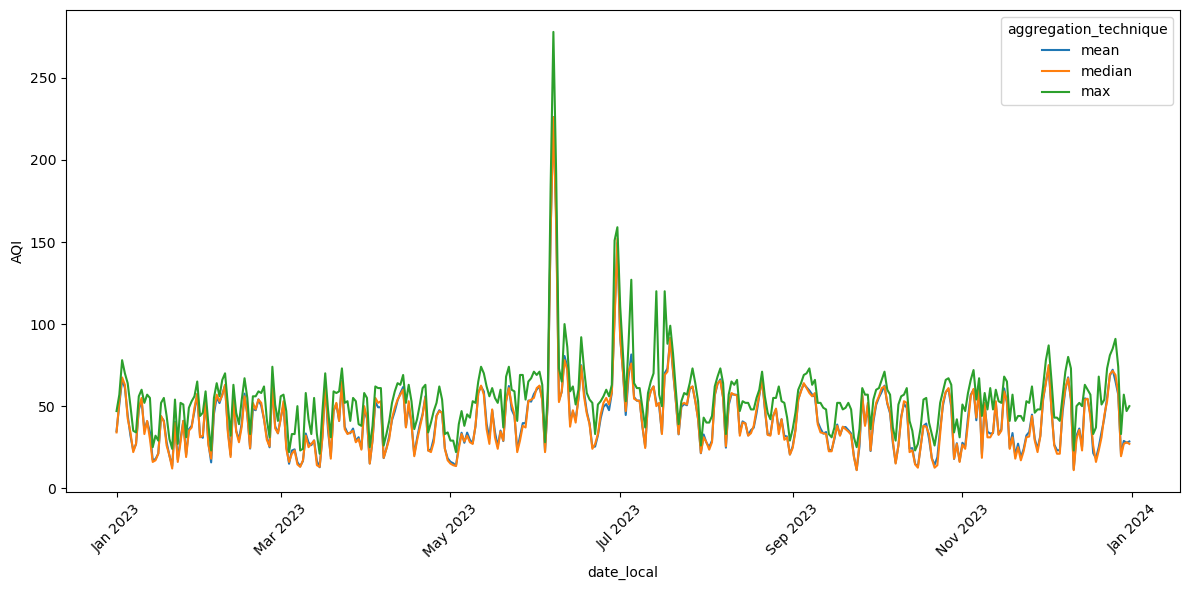

In [7]:
# Compare different aggregation methods for AQI 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

agg_ny_daily_pm25 = ny_daily_pm25.groupby(['date_local']).agg(mean=('aqi', 'mean'), median=('aqi', 'median'), max=('aqi', 'max')).reset_index()
agg_ny_daily_pm25['date_local'] = pd.to_datetime(agg_ny_daily_pm25['date_local'], format='%Y-%m-%d')

# Convert to long format for Seaborn
agg_ny_daily_pm25 = agg_ny_daily_pm25.melt(id_vars='date_local', var_name='aggregation_technique', value_name='AQI')

plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_ny_daily_pm25, x='date_local', y='AQI', hue='aggregation_technique')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Determine how many years of data are available 
# There seems to be sufficient data going back to the start of 2020 through end of 2024 (error on 2025)

# Try to go back to 2020
url = "https://aqs.epa.gov/data/api/dailyData/byCBSA"
date_counts = {}

for year in ['2020', '2021', '2022', '2023', '2024']:
    params = {
        'email': email, 
        'key': api_key, 
        'param': '88101', 
        'bdate': f'{year}0101', 
        'edate': f'{year}1231', 
        'cbsa': '35620'
    }

    # Comment out for now, execution not needed 
    # df = get_aqs_data(url, params=params)
    # dates = df['date_local'].nunique()
    # rows = df.shape[0]

    # date_counts[year] = (dates, rows)
    
date_counts

{}

In [9]:
# Select top 20 CBSAs (population size) for analysis, make sure they exist in AQS data

cbsa['code'] = cbsa['code'].astype(int)

top_20_cbsa = pd.read_csv('data/top_20_cbsa.csv', header=0)
top_20_cbsa = list(top_20_cbsa['code'])

cbsa[cbsa['code'].isin(top_20_cbsa)].sort_values('value_represented')

,code,value_represented
53,12060,"Atlanta-Sandy Springs-Roswell, GA"
64,12580,"Baltimore-Columbia-Towson, MD"
113,14460,"Boston-Cambridge-Newton, MA-NH"
174,16980,"Chicago-Naperville-Elgin, IL-IN-WI"
228,19100,"Dallas-Fort Worth-Arlington, TX"
244,19740,"Denver-Aurora-Lakewood, CO"
247,19820,"Detroit-Warren-Dearborn, MI"
415,26420,"Houston-The Woodlands-Sugar Land, TX"
535,31080,"Los Angeles-Long Beach-Anaheim, CA"
590,33100,"Miami-Fort Lauderdale-West Palm Beach, FL"


In [10]:
# Test how many CBSAs can be queried at once 
# Seems that only one CBSA can be queried at once 

string_top_20_cbsa = [f'{cbsa}' for cbsa in top_20_cbsa]
url = 'https://aqs.epa.gov/data/api/dailyData/byCBSA'
params = {
    'email': email, 
    'key': api_key, 
    'param': '88101', 
    'bdate': f'20200101', 
    'edate': f'20201231', 
    'cbsa': string_top_20_cbsa
}
df = get_aqs_data(url, params=params)

Successfully got data.


In [11]:
# Get daily PM2.5 AQI data from top 20 CBSAs, 2020-2024

import time

url = 'https://aqs.epa.gov/data/api/dailyData/byCBSA'

daily_pm25_top_20_cbsa = pd.DataFrame()

for cbsa in top_20_cbsa:
    for year in ['2020', '2021', '2022', '2023', '2024']:
        params = {
            'email': email, 
            'key': api_key, 
            'param': '88101', 
            'bdate': f'{year}0101', 
            'edate': f'{year}1231', 
            'cbsa': cbsa
        }
        # print(cbsa, f'{year}0101', f'{year}1231')
        
        # df = get_aqs_data(url, params=params)
        # daily_pm25_top_20_cbsa = pd.concat([daily_pm25_top_20_cbsa, df])

        # time.sleep(1)

In [12]:
# Save data locally 

# daily_pm25_top_20_cbsa.to_parquet('data/daily_pm25_top_20_cbsa.parquet', index=False, engine='fastparquet')
daily_pm25_top_20_cbsa = pd.read_parquet('data/daily_pm25_top_20_cbsa.parquet', engine='fastparquet')

daily_pm25_top_20_cbsa.shape

(4169072, 32)

In [13]:
# Check daily dataset 

# How many CBSAs? 20
daily_pm25_top_20_cbsa['cbsa'].nunique()

# How much data for each CBSA? More than 50k rows for each CBSA, looks fine
daily_pm25_top_20_cbsa.groupby('cbsa')['aqi'].count()

# How many days of data for each CBSA? Each CBSA has full year of data, looks fine
daily_pm25_top_20_cbsa.groupby('cbsa')['date_local'].nunique()/5

daily_pm25_top_20_cbsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4169072 entries, 0 to 4169071
Data columns (total 32 columns):
 #   Column                Dtype  
---  ------                -----  
 0   state_code            object 
 1   county_code           object 
 2   site_number           object 
 3   parameter_code        object 
 4   poc                   int64  
 5   latitude              float64
 6   longitude             float64
 7   datum                 object 
 8   parameter             object 
 9   sample_duration_code  object 
 10  sample_duration       object 
 11  pollutant_standard    object 
 12  date_local            object 
 13  units_of_measure      object 
 14  event_type            object 
 15  observation_count     int64  
 16  observation_percent   float64
 17  validity_indicator    object 
 18  arithmetic_mean       float64
 19  first_max_value       float64
 20  first_max_hour        int64  
 21  aqi                   float64
 22  method_code           object 
 23  method 

In [14]:
# Create daily CBSA-level daily dataset

final_pm25_daily = daily_pm25_top_20_cbsa.groupby(['cbsa', 'cbsa_code', 'date_local']).agg(aqi=('aqi', 'mean')).reset_index()
final_pm25_daily['date_local'] = pd.to_datetime(final_pm25_daily['date_local'], format='%Y-%m-%d')
final_pm25_daily['cbsa_code'] = final_pm25_daily['cbsa_code'].astype(int)
final_pm25_daily.head()

,cbsa,cbsa_code,date_local,aqi
0,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-01,33.8
1,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-02,53.2
2,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-03,37.2
3,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-04,20.4
4,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-05,29.8


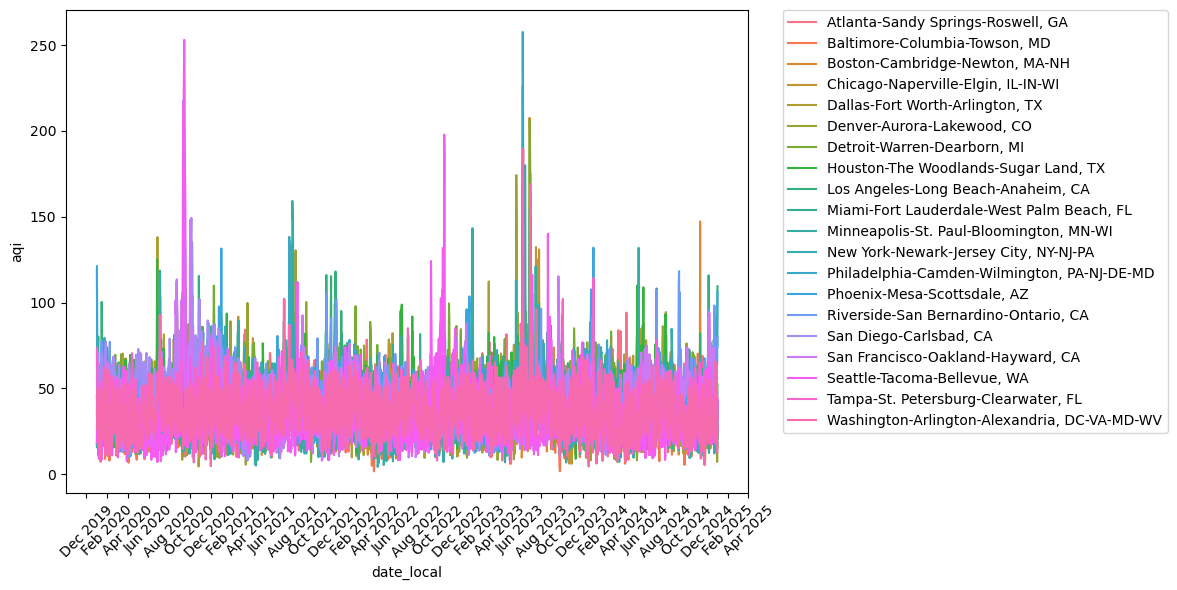

In [15]:
# Plot all 20 CBSA series 

plt.figure(figsize=(12, 6))
sns.lineplot(data=final_pm25_daily, x='date_local', y='aqi', hue='cbsa')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Site-level environmental Data

After exploring the health outcome data, it became clear that datasets with the same level of granularity as our environmental data were either unavailable or not easily accessible.

Using data from the NYC Syndromic Surveillance System, it is possible to create borough-level datasets of health outcomes on a daily basis. Given this, the next step is to refine the environmental dataset, originally at the CBSA level, to a more granular, site-specific level. To identify appropriate monitoring sites, I will use this [interactive site map](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=5f239fd3e72f424f98ef3d5def547eb5&extent=-146.2334,13.1913,-46.3896,56.5319) provided by the EPA.

In [16]:
# Get states list 

url = 'https://aqs.epa.gov/data/api/list/states'
params = {
    'email': email, 
    'key': api_key
}

states = get_aqs_data(url, params)
states[states['value_represented']=='New York']

Successfully got data.


,code,value_represented
32,36,New York


In [17]:
# Get counties by state list 

url = 'https://aqs.epa.gov/data/api/list/countiesByState'
params = {
    'email': email, 
    'key': api_key, 
    'state': '36' # New York
}
counties_ny = get_aqs_data(url, params)
counties_ny[counties_ny['value_represented'].isin(['New York', 'Kings', 'Bronx', 'Queens'])]

Successfully got data.


,code,value_represented
2,005,Bronx
23,047,Kings
30,061,New York
40,081,Queens


In [18]:
# Site numbers from interactive map

map_info = {
    'Manhattan': {
        'county': '061', 
        'sites': ['0128', '0079']
    }, 
    'Brooklyn': {
        'county': '047', 
        'sites': ['0122', '0118', '0052']
    }, 
    'Bronx': {
        'county': '005', 
        'sites': ['0110', '0112', '0133']
    }, 
    'Queens': {
        'county': '081', 
        'sites': ['0124', '0125']
    }
}

rows = []
for borough, info in map_info.items():
    for site in info['sites']:
        rows.append({
            'borough': borough, 
            'county': info['county'], 
            'site': site
        })

map_info = pd.DataFrame(rows)
map_info

,borough,county,site
0,Manhattan,061,0128
1,Manhattan,061,0079
2,Brooklyn,047,0122
3,Brooklyn,047,0118
4,Brooklyn,047,0052
5,Bronx,005,0110
6,Bronx,005,0112
7,Bronx,005,0133
8,Queens,081,0124
9,Queens,081,0125


In [19]:
# Get site data 

# url = 'https://aqs.epa.gov/data/api/dailyData/bySite'
# daily_pm25_ny = pd.DataFrame()

# for index, row in map_info.iterrows():
#     for year in ['2020', '2021', '2022', '2023', '2024', '2025']:
#         params = {
#             'email': email, 
#             'key': api_key, 
#             'param': '88101', 
#             'bdate': f'{year}0101', 
#             'edate': f'{year}1231',
#             'state': '36', # New York, 
#             'county': row['county'], 
#             'site': row['site']
#         }
        
#         print(year, row['borough'], row['site'])

#         df = get_aqs_data(url, params)
#         if df is not None:
#             df['borough'] = row['borough']

#         daily_pm25_ny = pd.concat([daily_pm25_ny, df])
        
#         print('\n')
#         time.sleep(1)

# daily_pm25_ny.info()

In [20]:
# Save data locally 

# daily_pm25_ny.to_parquet('data/daily_pm25_ny.parquet', index=False, engine='fastparquet')
daily_pm25_ny = pd.read_parquet('data/daily_pm25_ny.parquet', engine='fastparquet')

daily_pm25_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100706 entries, 0 to 100705
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   state_code            100706 non-null  object 
 1   county_code           100706 non-null  object 
 2   site_number           100706 non-null  object 
 3   parameter_code        100706 non-null  object 
 4   poc                   100706 non-null  int64  
 5   latitude              100706 non-null  float64
 6   longitude             100706 non-null  float64
 7   datum                 100706 non-null  object 
 8   parameter             100706 non-null  object 
 9   sample_duration_code  100706 non-null  object 
 10  sample_duration       100706 non-null  object 
 11  pollutant_standard    90824 non-null   object 
 12  date_local            100706 non-null  object 
 13  units_of_measure      100706 non-null  object 
 14  event_type            100706 non-null  object 
 15  

In [21]:
# Check and clean daily site data 

# How many boroughs? 4 
daily_pm25_ny['borough'].nunique()

# How much data for each site? More than 1k rows at the very least, we're fine 
daily_pm25_ny.groupby(['borough', 'site_number'])['aqi'].count().reset_index().sort_values(['borough', 'aqi'])

# How many days of data for each site? Seems that many sites have partial data
daily_pm25_ny.groupby(['borough', 'site_number'])['date_local'].nunique()/5

# Check cutoff dates for each site. We still have coverage across all 5 years despite partial data. 
daily_pm25_ny.groupby(['borough', 'site_number'])['date_local'].agg(['min', 'max']).reset_index().sort_values('borough')

# Check cutoff dates for each borough
daily_pm25_ny.groupby(['borough'])['date_local'].agg(['min', 'max', 'nunique']).reset_index().sort_values('borough')

,borough,min,max,nunique
0,Bronx,2020-01-01,2024-12-31,1801
1,Brooklyn,2020-01-01,2024-12-31,910
2,Manhattan,2020-01-01,2024-12-29,550
3,Queens,2020-01-01,2024-12-31,1819


In [22]:
# Create final site-level dataset

final_daily_pm25_ny = daily_pm25_ny.groupby(['borough', 'date_local']).agg(aqi=('aqi', 'mean')).reset_index()
final_daily_pm25_ny['date_local'] = pd.to_datetime(final_daily_pm25_ny['date_local'], format='%Y-%m-%d')
final_daily_pm25_ny.head()

,borough,date_local,aqi
0,Bronx,2020-01-01,18.50
1,Bronx,2020-01-02,53.50
2,Bronx,2020-01-03,61.50
3,Bronx,2020-01-04,55.75
4,Bronx,2020-01-05,12.50


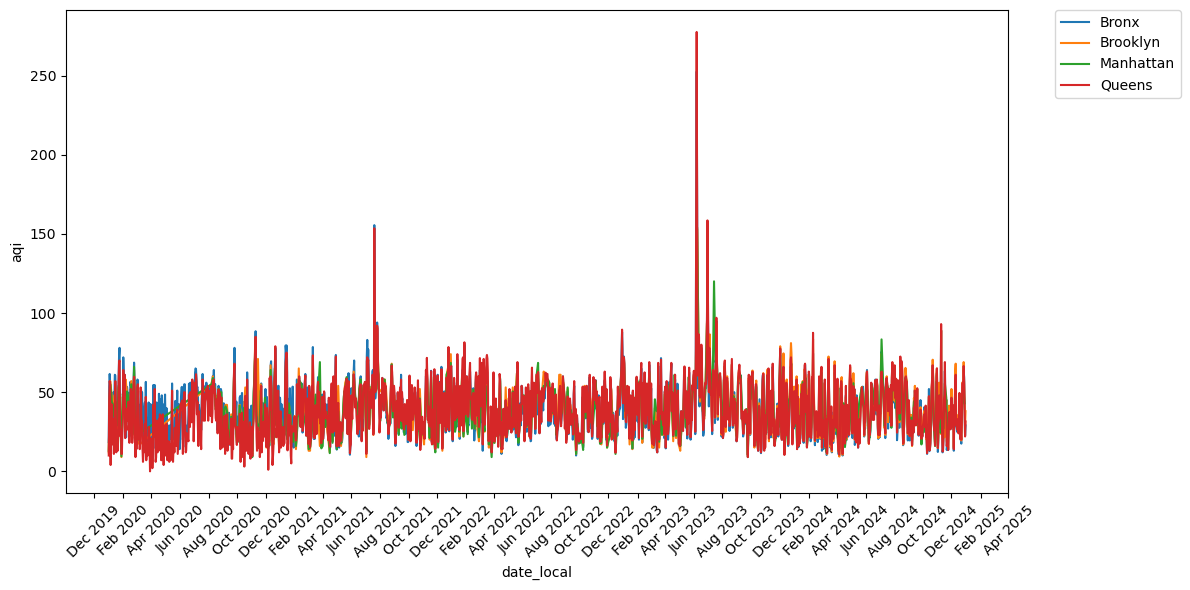

In [23]:
# Plot AQI series for all 4 boroughs included 

plt.figure(figsize=(12, 6))
sns.lineplot(data=final_daily_pm25_ny, x='date_local', y='aqi', hue='borough')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Health outcome data

Given the geo-experiment parameters outlined in the section titled "Identifying Natural Experiments," the health outcome data should cover the following date range:
- **Start date:** February 9, 2023 (beginning of the pre-test period)
- **End date:** February 19, 2024 (end of the cooldown period)

Although somewhat manual, I will use the [Syndromic Surveillance Data dashboard](https://a816-health.nyc.gov/hdi/epiquery/visualizations?PageType=ps&PopulationSource=Syndromic) to download daily-level data on emergency department visits related to asthma and other respiratory symptoms for this period.

In [24]:
# Read in raw health outcome data

root = 'data/health_outcomes'

complaint = 'asthma'
file = f'{root}/{complaint}.csv'
asthma_raw_data = pd.read_csv(file, sep='\t', encoding='utf-16')
asthma_raw_data['complaint'] = complaint

complaint = 'respiratory'
file = f'{root}/{complaint}.csv'
respiratory_raw_data = pd.read_csv(file, sep='\t', encoding='utf-16')
respiratory_raw_data['complaint'] = complaint


health_raw_data = pd.concat([asthma_raw_data, respiratory_raw_data])
health_raw_data.head()

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/2230230422.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  asthma_raw_data = pd.read_csv(file, sep='\t', encoding='utf-16')
/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/2230230422.py:12: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  respiratory_raw_data = pd.read_csv(file, sep='\t', encoding='utf-16')


,Data note 1,Data note 2,Dim1Name,Zip,Dim2Name,Dim2Value,Date,Count,Unnamed: 8,complaint
0,-Syndrome data are inherently non-specific and...,-Geographic data may not add up to citywide co...,Citywide,Citwide,Age Group,All age groups,1/23/23,199,NaN,asthma
1,-Syndrome data are inherently non-specific and...,-Geographic data may not add up to citywide co...,Citywide,Citwide,Age Group,All age groups,1/24/23,182,NaN,asthma
2,-Syndrome data are inherently non-specific and...,-Geographic data may not add up to citywide co...,Citywide,Citwide,Age Group,All age groups,1/25/23,171,NaN,asthma
3,-Syndrome data are inherently non-specific and...,-Geographic data may not add up to citywide co...,Citywide,Citwide,Age Group,All age groups,1/26/23,170,NaN,asthma
4,-Syndrome data are inherently non-specific and...,-Geographic data may not add up to citywide co...,Citywide,Citwide,Age Group,All age groups,1/27/23,181,NaN,asthma


In [25]:
# Clean up health outcome data

import numpy as np

bronx_zips = [10467,10456,10458,10453,10468,
              10457,10452,10469,10462,10466,
              10463,10472,10460,10473,10451,
              10461,10459,10465,10475,10455,
              10454,10471,10474,10470,10803,
              10464,10499]

queens_zips = [11368,11385,11373,11377,11355,
               11375,11691,11372,11432,11434,
               11435,11354,11420,11419,11374,
               11413,11365,11357,11421,11412,
               11367,11433,11378,11379,11105,
               11364,11106,11358,11418,11101,
               11103,11422,11417,11423,11414,
               11369,11361,11001,11102,11429,
               11416,11104,11356,11427,11370,
               11428,11426,11694,11436,11692,
               11411,11360,11415,11362,11004,
               11693,11366,11096,11363,11109,
               11697,11005,11424,11430,11390,
               11371,11451,11690,11695,11120,
               11351,11352,11359,11380,11381,
               11386,11405,11425,11431,11439,
               11499,11437]

health = health_raw_data[health_raw_data['Zip'].isin(bronx_zips + queens_zips)].copy()
health = health[health['Dim2Value']=='All age groups']

health.drop(columns=['Data note 1', 'Data note 2', 'Unnamed: 8', 'Dim1Name', 'Dim2Name', 'Dim2Value'], inplace=True)
health['Zip'] = health['Zip'].astype(int)
health['Date '] = pd.to_datetime(health['Date '], format='%m/%d/%y')
health.rename(columns={'Zip': 'zip', 'Date ': 'date', 'Count':'count'}, inplace=True)
health['count'] = health['count'].astype(int)

health['borough'] = np.where(health['zip'].isin(bronx_zips), 'Bronx', 'Queens')
health = health.reset_index(drop=True)

health.head()

,zip,date,count,complaint,borough
0,10451,2023-01-23,4,asthma,Bronx
1,10451,2023-01-24,1,asthma,Bronx
2,10451,2023-01-25,0,asthma,Bronx
3,10451,2023-01-26,2,asthma,Bronx
4,10451,2023-01-27,2,asthma,Bronx


In [26]:
# Check health data

health['borough'].unique()
health['date'].nunique()
health['date'].unique()
health.info()
health.groupby('borough')['date'].nunique()
health.groupby(['borough', 'zip'])['date'].nunique()
health.groupby(['borough', 'zip'])['date'].nunique()
health.groupby(['borough', 'zip', 'complaint'])['date'].nunique()
health['date'].agg(['min', 'max'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49786 entries, 0 to 49785
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   zip        49786 non-null  int64         
 1   date       49786 non-null  datetime64[ns]
 2   count      49786 non-null  int64         
 3   complaint  49786 non-null  object        
 4   borough    49786 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.9+ MB


min   2023-01-23
max   2024-03-01
Name: date, dtype: datetime64[ns]

In [27]:
health.head()

,zip,date,count,complaint,borough
0,10451,2023-01-23,4,asthma,Bronx
1,10451,2023-01-24,1,asthma,Bronx
2,10451,2023-01-25,0,asthma,Bronx
3,10451,2023-01-26,2,asthma,Bronx
4,10451,2023-01-27,2,asthma,Bronx


# EDA

## CBSA-level environmental data

We currently have a robust dataset for air quality: daily CBSA-level AQI measurements for PM2.5.

- **PM2.5** refers to fine particulate matter in the air that is 2.5 micrometers or smaller in diameter. These particles are small enough to be inhaled and penetrate deep into the lungs, posing significant health risks. PM2.5 is a major component of smog and is linked to various respiratory and cardiovascular problems.

Other environmental factors, such as daily meteorological conditions (e.g., temperature, humidity), may also be relevant. However, for the purpose of analyzing a geo experiment, AQI is the most critical variable. Additional factors might be considered for "market matching" or covariate adjustment.

In [28]:
# Make copy of data for exploration

eda_final_pm25_daily = final_pm25_daily.copy()

In [29]:
# Understand type/shape of data 

eda_final_pm25_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36526 entries, 0 to 36525
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   cbsa        36526 non-null  object        
 1   cbsa_code   36526 non-null  int64         
 2   date_local  36526 non-null  datetime64[ns]
 3   aqi         36516 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [30]:
# Understand 10 null values for mean_aqi
# Null values seem to be error in data, as other columns are populated for those days
# Only 10 total days (from 36K+ observations) across all 20 CBSAs with null AQI values, disregard for now 

import datetime

eda_final_pm25_daily[eda_final_pm25_daily['aqi'].isnull()].sort_values(['cbsa', 'date_local'])

daily_pm25_top_20_cbsa[(daily_pm25_top_20_cbsa['cbsa_code'] == '41860') & (daily_pm25_top_20_cbsa['aqi'].isnull())]

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
2648150,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648151,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648152,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648175,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
2648183,06,001,0015,88101,3,37.701222,-121.903019,NAD83,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Pleasanton - Owens Ct,Owens Ct.,California,Alameda,Pleasanton,41860,"San Francisco-Oakland-Hayward, CA",2024-08-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792261,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792270,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792279,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28
2792288,06,013,1004,88101,3,37.960400,-122.356811,WGS84,PM2.5 - Local Conditions,1,...,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,San Pablo,"1865 D RUMRILL BLVD, San Pablo",California,Contra Costa,San Pablo,41860,"San Francisco-Oakland-Hayward, CA",2025-04-28


In [31]:
# See distributions 

eda_final_pm25_daily.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
cbsa_code,36526.0,30499.166073,12060.0,19100.0,33100.0,40140.0,47900.0,11512.34887
date_local,36526,2022-07-01 18:42:40.586979072,2020-01-01 00:00:00,2021-04-01 00:00:00,2022-07-02 00:00:00,2023-10-01 00:00:00,2024-12-31 00:00:00,NaN
aqi,36516.0,40.858397,1.75,29.0,39.875,51.486185,257.605263,16.20307


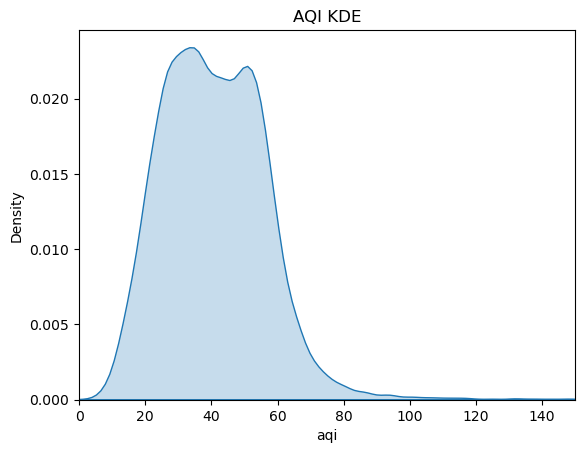

In [32]:
# Plot distribution of AQI 
# Appears to have slight bimodal distribution centered around 30 and 60

sns.kdeplot(data=eda_final_pm25_daily, x='aqi', fill=True)
plt.title('AQI KDE')
plt.xlim(0, 150)
plt.show()

In [33]:
# Map CBSA codes to regions

cbsa_region_map = {
    35620: "Northeast",  # New York-Newark-Jersey City, NY-NJ-PA
    37980: "Northeast",  # Philadelphia-Camden-Wilmington, PA-NJ-DE-MD
    14460: "Northeast",  # Boston-Cambridge-Newton, MA-NH
    12580: "Northeast",  # Baltimore-Columbia-Towson, MD
    47900: "Northeast",  # Washington-Arlington-Alexandria, DC-VA-MD-WV

    12060: "Southeast",  # Atlanta-Sandy Springs-Alpharetta, GA
    33100: "Southeast",  # Miami-Fort Lauderdale-West Palm Beach, FL
    45300: "Southeast",  # Tampa-St. Petersburg-Clearwater, FL

    16980: "Midwest",    # Chicago-Naperville-Elgin, IL-IN-WI
    19820: "Midwest",    # Detroit-Warren-Dearborn, MI
    33460: "Midwest",    # Minneapolis-St. Paul-Bloomington, MN-WI

    19100: "South Central",  # Dallas-Fort Worth-Arlington, TX
    26420: "South Central",  # Houston-The Woodlands-Sugar Land, TX

    31080: "West",       # Los Angeles-Long Beach-Anaheim, CA
    41860: "West",       # San Francisco-Oakland-Berkeley, CA
    41740: "West",       # San Diego-Chula Vista-Carlsbad, CA
    40140: "West",       # Riverside-San Bernardino-Ontario, CA
    38060: "West",       # Phoenix-Mesa-Chandler, AZ
    19740: "West",       # Denver-Aurora-Lakewood, CO
    42660: "West"        # Seattle-Tacoma-Bellevue, WA
}

eda_final_pm25_daily['region'] = eda_final_pm25_daily['cbsa_code'].map(cbsa_region_map)
eda_final_pm25_daily['region'].value_counts()

region
West             12779
Northeast         9134
Midwest           5481
Southeast         5478
South Central     3654
Name: count, dtype: int64

In [34]:
# Plot each region as a subplot

# g = sns.FacetGrid(
#     eda_final_pm25_daily, 
#     col='region', 
#     col_order=["Northeast", "Southeast", "Midwest", "South Central", "West"], 
#     col_wrap=2, 
#     height=3, 
#     aspect=1.5, 
#     sharey=True
# )

# g.map_dataframe(
#     sns.lineplot, 
#     x='date_local', 
#     y='aqi', 
#     hue='cbsa'
# )

# g.set_titles('{col_name} Region')

# plt.tight_layout()
# plt.show()

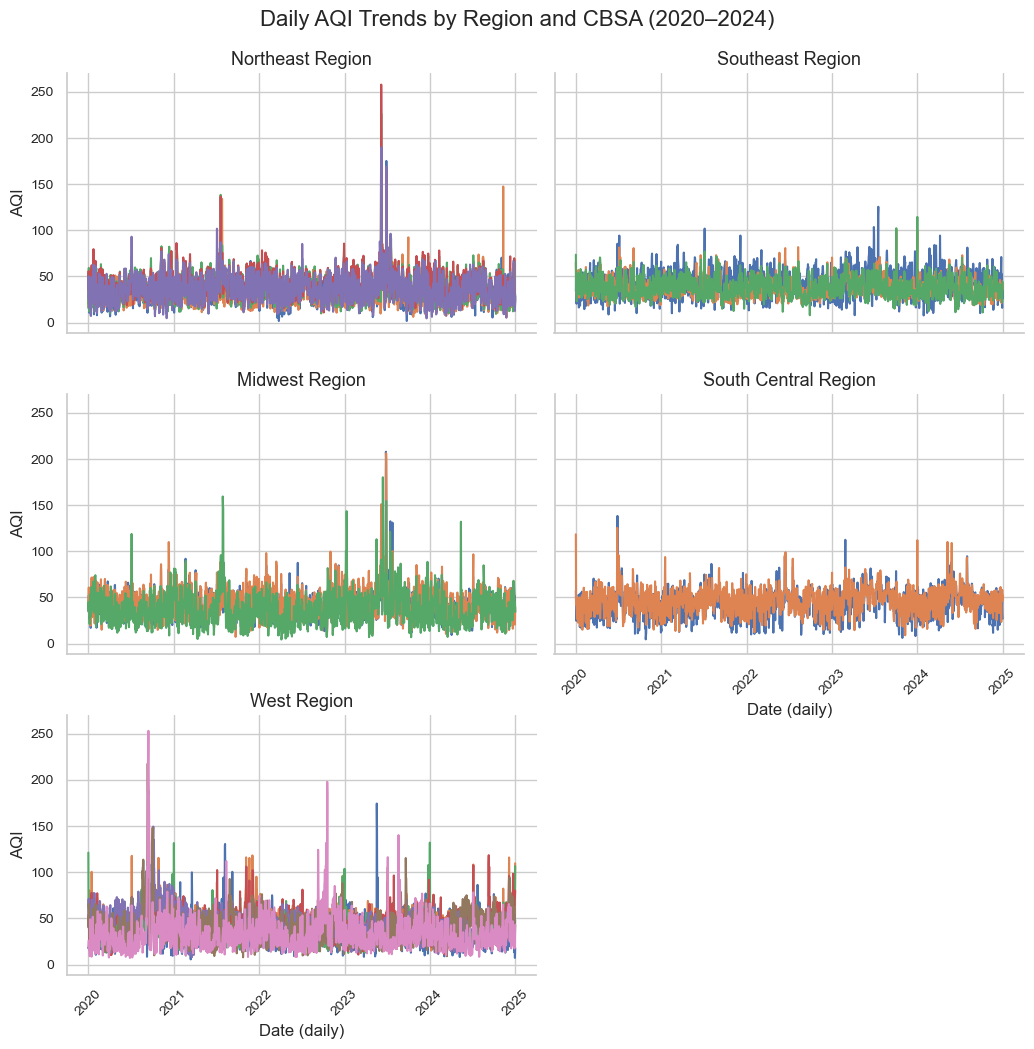

In [35]:
# Global style
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.autolayout': False  # We’ll manually control spacing
})

# Create the FacetGrid
g = sns.FacetGrid(
    eda_final_pm25_daily, 
    col='region', 
    col_order=["Northeast", "Southeast", "Midwest", "South Central", "West"], 
    col_wrap=2, 
    height=3.5, 
    aspect=1.5, 
    sharey=True,
    legend_out=False
)

# Plot data
g.map_dataframe(sns.lineplot, x='date_local', y='aqi', hue='cbsa', legend=False)

# Set facet titles and axis labels
g.set_titles('{col_name} Region', size=13)
g.set_axis_labels('Date (daily)', 'AQI')

# Rotate x-axis ticks
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Add a master title
g.figure.suptitle('Daily AQI Trends by Region and CBSA (2020–2024)', fontsize=16, y=0.98)

# Adjust spacing to accommodate title
g.figure.subplots_adjust(top=0.92)

plt.show()

In [36]:
# Confirm greater presence of outliers in West, Midwest, and Northeast regions 

eda_final_pm25_daily.groupby('region')['aqi'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Midwest,5481.0,42.049663,17.309456,4.363636,29.333333,41.079137,53.157895,207.621849
Northeast,9133.0,37.293172,15.692249,1.750000,26.181818,35.500000,47.655172,257.605263
South Central,3653.0,45.473492,14.098476,4.600000,35.800000,46.000000,54.727273,138.166667
Southeast,5476.0,39.903477,12.643844,7.777778,30.500000,38.146429,48.600000,125.400000
West,12773.0,41.985936,17.411425,5.615385,29.000000,41.666667,52.769231,253.000000


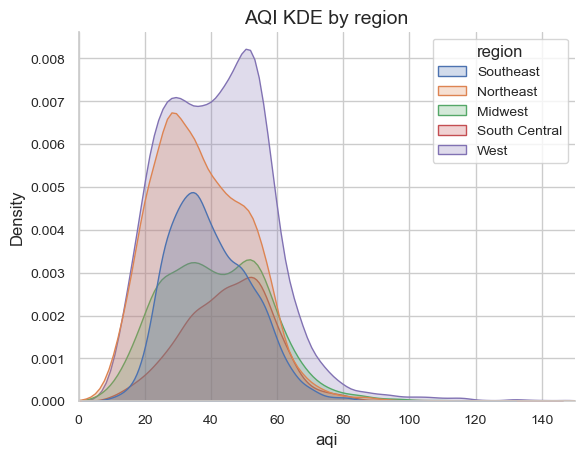

In [37]:
# Compare regional AQI distributions 

sns.kdeplot(data=eda_final_pm25_daily, x='aqi', hue='region', fill=True)
plt.title('AQI KDE by region')
plt.xlim(0, 150)
plt.show()

In [38]:
# Group observations into seasons 

eda_final_pm25_daily['month'] = eda_final_pm25_daily['date_local'].dt.month

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
eda_final_pm25_daily['season'] = eda_final_pm25_daily['month'].apply(assign_season)
eda_final_pm25_daily.head()

,cbsa,cbsa_code,date_local,aqi,region,month,season
0,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-01,33.8,Southeast,1,Winter
1,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-02,53.2,Southeast,1,Winter
2,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-03,37.2,Southeast,1,Winter
3,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-04,20.4,Southeast,1,Winter
4,"Atlanta-Sandy Springs-Roswell, GA",12060,2020-01-05,29.8,Southeast,1,Winter


In [39]:
# Describe AQI by season 

eda_final_pm25_daily.groupby('season')['aqi'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
Fall,9095.0,40.722725,17.052231,1.800000,28.727273,39.250000,51.333333,253.000000
Spring,9185.0,37.242679,14.352357,1.750000,26.090909,36.125000,48.142857,174.272727
Summer,9196.0,44.030557,16.979592,7.142857,32.163462,43.833333,53.592771,257.605263
Winter,9040.0,41.441706,15.542834,4.571429,29.567460,40.555556,52.085227,143.338710


In [40]:
# Group by region too

eda_final_pm25_daily.groupby(['region', 'season'])['aqi'].describe()

count       mean        std        min        25%  \
region        season                                                       
Midwest       Fall    1365.0  39.135047  14.699829   6.888889  28.380952   
              Spring  1380.0  36.979182  15.429699   4.363636  24.495510   
              Summer  1380.0  46.250543  20.592258   9.428571  32.636364   
              Winter  1356.0  45.868615  15.907918   8.666667  33.644101   
Northeast     Fall    2275.0  34.548103  13.233376   1.800000  25.000000   
              Spring  2298.0  32.260588  12.979545   1.750000  22.198413   
              Summer  2300.0  43.761085  18.482543   7.666667  31.916429   
              Winter  2260.0  38.591275  14.919073   4.571429  26.857143   
South Central Fall     910.0  43.424941  12.877917   4.600000  34.458333   
              Spring   920.0  46.221551  13.965845  11.000000  36.830357   
              Summer   919.0  51.310499  14.007097   9.500000  42.437500   
              Winter   904.0  40.840479  13.342014   8.125000  31.708333   
Southeast     Fall    1360.0  37.065344  12.501926   8.000000  27.588235   
              Spring  1380.0  41.699754  12.028591   8.000000  33.068182   
              Summer  1380.0  41.168661  13.623596  11.250000  30.750000   
              Winter  1356.0  39.634336  11.831467   7.777778  31.000000   
West          Fall    3185.0  46.603249  20.690506   7.900000  33.200000   
              Spring  3207.0  36.432308  14.095070   5.615385  25.297059   
              Summer  3217.0  42.418916  15.468329   7.142857  30.727273   
              Winter  3164.0  42.526847  17.184865   7.222222  28.860795   

                            50%        75%         max  
region        season                                    
Midwest       Fall    38.500000  50.606061   99.555556  
              Spring  35.612429  49.240196  131.900000  
              Summer  44.267361  55.465909  207.621849  
              Winter  46.493607  56.574653  143.338710  
Northeast     Fall    33.166667  43.666667  147.307692  
              Spring  30.392308  41.296429   76.648649  
              Summer  42.558442  52.743056  257.605263  
              Winter  37.112632  49.864394   86.066667  
South Central Fall    44.681818  53.500000   81.875000  
              Spring  46.535714  55.454545  110.000000  
              Summer  51.461538  59.000000  138.166667  
              Winter  40.690476  49.850000  118.285714  
Southeast     Fall    34.720779  45.000000  102.142857  
              Spring  40.387500  49.700000   94.200000  
              Summer  39.214286  50.113636  125.400000  
              Winter  38.200000  47.836397  114.400000  
West          Fall    45.615385  55.850000  253.000000  
              Spring  35.000000  47.763636  174.272727  
              Summer  43.818182  52.727273  140.100000  
              Winter  41.845238  54.000000  132.000000

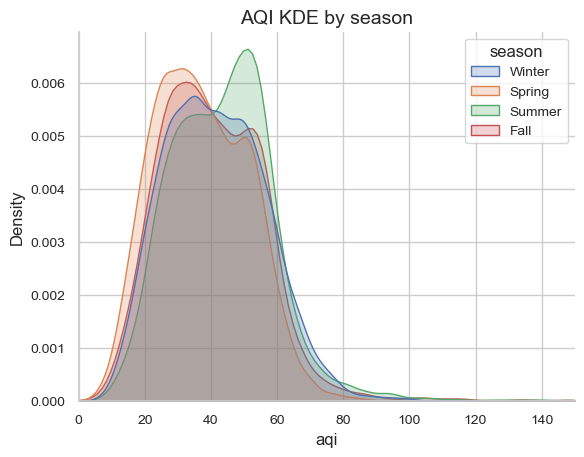

In [41]:
# Compare seasonal AQI distributions 

sns.kdeplot(data=eda_final_pm25_daily, x='aqi', hue='season', fill=True)
plt.title('AQI KDE by season')
plt.xlim(0, 150)
plt.show()

In [42]:
# Generate lowess smoothed time series to uncover general trends/seasonal effects

from statsmodels.nonparametric.smoothers_lowess import lowess

# Pick one CBSA from each region to test LOWESS smoothing
lowess_cbsa = [35620, 33100, 16980, 19100, 31080]
subsample_lowess = eda_final_pm25_daily[eda_final_pm25_daily['cbsa_code'].isin(lowess_cbsa)].copy()
subsample_lowess['year'] = subsample_lowess['date_local'].dt.year
subsample_lowess['day_of_year'] = subsample_lowess['date_local'].dt.strftime('%m-%d')

def calculate_lowess(group):
    # Return different options for smoothin span
    group['lowess_smoothed_01'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.01)[:, 1]
    group['lowess_smoothed_025'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.025)[:, 1]
    group['lowess_smoothed_05'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.05)[:, 1]
    group['lowess_smoothed_10'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.10)[:, 1]
    group['lowess_smoothed_15'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.15)[:, 1]
    group['lowess_smoothed_20'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.20)[:, 1]
    group['lowess_smoothed_25'] = lowess(endog=group['aqi'], exog=group['date_local'], frac=0.25)[:, 1]
    
    return group

subsample_lowess = subsample_lowess.groupby('cbsa_code').apply(calculate_lowess)
subsample_lowess = subsample_lowess.reset_index(drop=True)
subsample_lowess.head()

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/717642686.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample_lowess = subsample_lowess.groupby('cbsa_code').apply(calculate_lowess)


,cbsa,cbsa_code,date_local,aqi,region,month,season,year,day_of_year,lowess_smoothed_01,lowess_smoothed_025,lowess_smoothed_05,lowess_smoothed_10,lowess_smoothed_15,lowess_smoothed_20,lowess_smoothed_25
0,"Chicago-Naperville-Elgin, IL-IN-WI",16980,2020-01-01,34.750000,Midwest,1,Winter,2020,01-01,37.938965,36.885739,45.683515,48.274802,46.441150,45.116629,43.135241
1,"Chicago-Naperville-Elgin, IL-IN-WI",16980,2020-01-02,39.898305,Midwest,1,Winter,2020,01-02,37.837234,37.578109,45.745055,48.203589,46.389060,45.082614,43.119061
2,"Chicago-Naperville-Elgin, IL-IN-WI",16980,2020-01-03,52.175676,Midwest,1,Winter,2020,01-03,37.831117,38.266526,45.803259,48.132060,46.337028,45.048657,43.102946
3,"Chicago-Naperville-Elgin, IL-IN-WI",16980,2020-01-04,44.947531,Midwest,1,Winter,2020,01-04,37.944389,38.950185,45.858075,48.060216,46.285056,45.014759,43.086896
4,"Chicago-Naperville-Elgin, IL-IN-WI",16980,2020-01-05,35.423729,Midwest,1,Winter,2020,01-05,38.180856,39.627681,45.909442,47.988056,46.233144,44.980921,43.070911


<Figure size 1500x500 with 0 Axes>

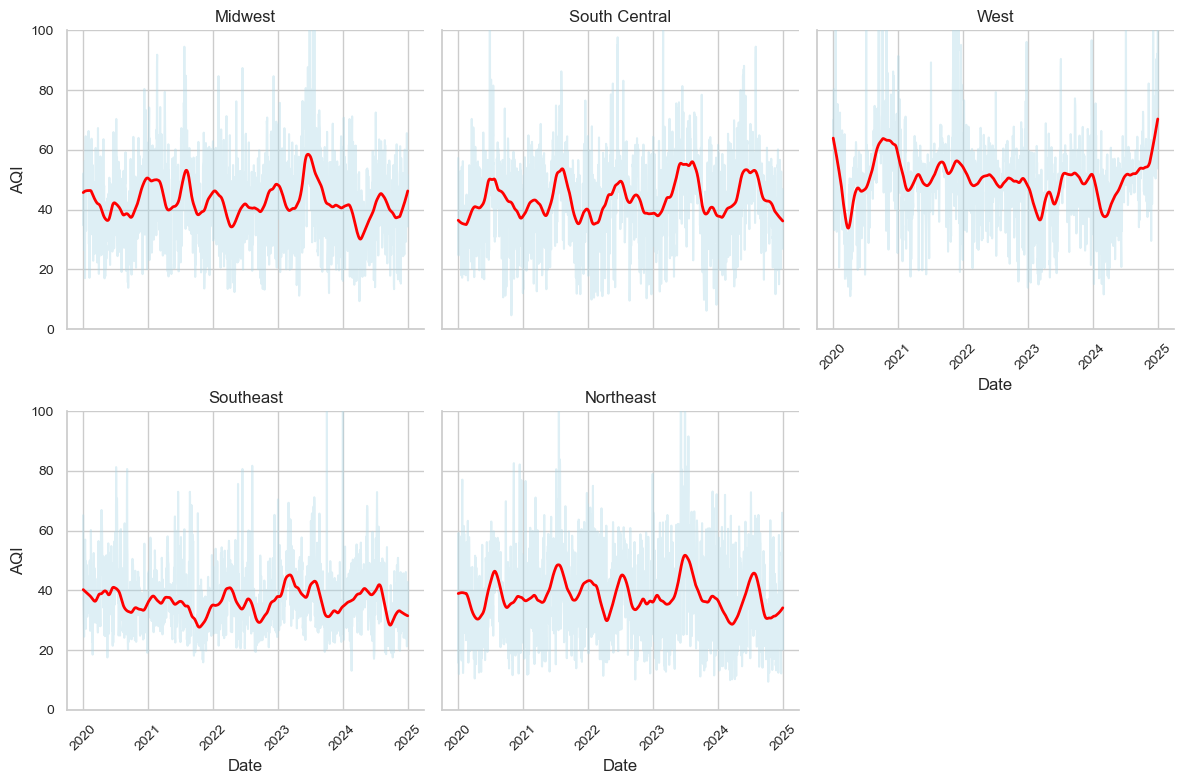

In [43]:
# Plot raw vs. lowess smoothed

plt.figure(figsize=(15, 5))

g = sns.FacetGrid(
    subsample_lowess,
    col='region',
    col_wrap=3,
    height=4,
    sharey=True,
    sharex=True
)

def plot_aqi_and_lowess(data, color, **kwargs):
    plt.plot(data['date_local'], data['aqi'], color='lightblue', alpha=0.4, label='AQI')
    plt.plot(data['date_local'], data['lowess_smoothed_05'], color='red', linewidth=2, label='LOWESS')
    plt.xticks(rotation=45)
    plt.legend()

g.map_dataframe(plot_aqi_and_lowess)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "AQI")
g.tight_layout()

plt.ylim(0, 100)

plt.show()

In [44]:
# # Plot for a single region, each year gets a different plot
# # Better visibility into seasonal trends 

# # Define seasonal tick positions
# season_ticks = {
#     'Winter': '01-01',
#     'Spring': '03-01',
#     'Summer': '06-01',
#     'Fall':   '09-01',
#     'Winter*': '12-01'  # distinguish end-of-year winter from Jan-Feb
# }

# def plot_seasonal_aqi(cbsa_code):
#     region_lowess = subsample_lowess[subsample_lowess['cbsa_code']==cbsa_code].copy()
#     region_lowess = region_lowess.sort_values('day_of_year')

#     g = sns.FacetGrid(
#         region_lowess,
#         row='year',
#         height=2,
#         aspect=5,       
#         sharex=False,      
#         sharey=True
#     )

#     g.map_dataframe(sns.lineplot, x='day_of_year', y='aqi', label='Raw AQI', color='gray', alpha=0.5)
#     g.map_dataframe(sns.lineplot, x='day_of_year', y='lowess_smoothed_05', label='LOWESS smoothed AQI', color='blue')


#     for ax in g.axes.flat:
#         ax.legend(loc='upper right')
#         ax.set_xticks(list(season_ticks.values()))
#         ax.set_xticklabels(list(season_ticks.keys()))

#     g.set_axis_labels('Calendar Date (MM-DD)', 'AQI')
#     g.set_titles('Year: {row_name}')

#     cbsa_name = region_lowess['cbsa'].iloc[0]
#     plt.subplots_adjust(hspace=0.4)
#     plt.ylim(0, 100)
#     plt.suptitle(f'Seasonal AQI trends for {cbsa_name}', fontsize=16, y=1.03)

#     plt.show()

# plot_seasonal_aqi(lowess_cbsa[0])
# # plot_seasonal_aqi(lowess_cbsa[1])
# # plot_seasonal_aqi(lowess_cbsa[2])
# # plot_seasonal_aqi(lowess_cbsa[3])
# # plot_seasonal_aqi(lowess_cbsa[4])

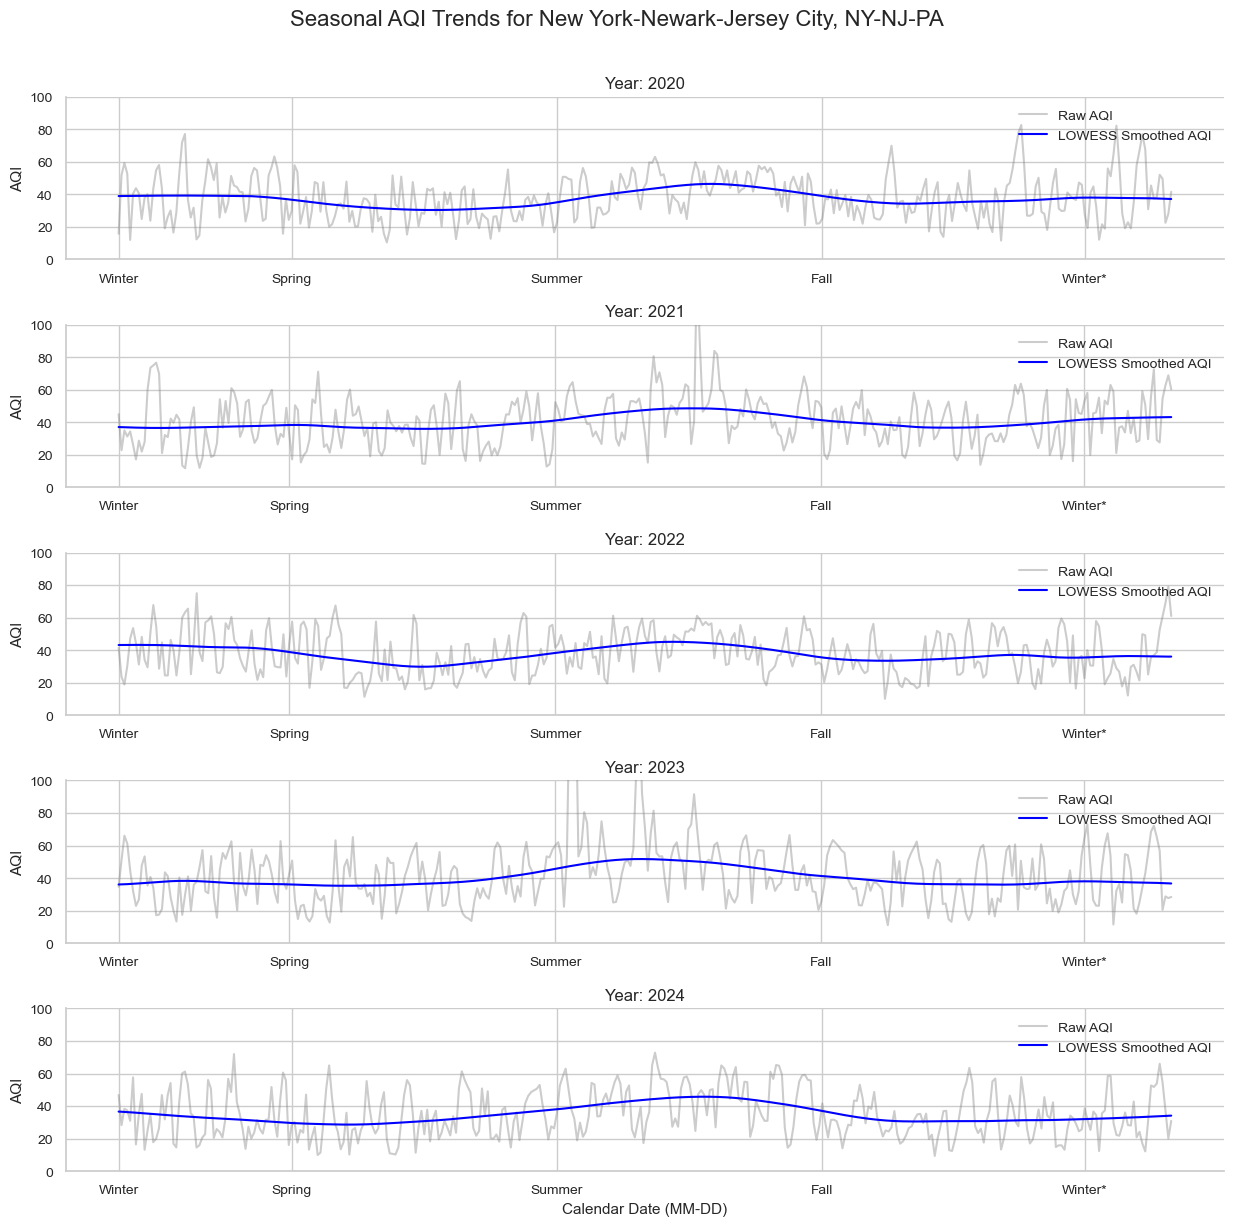

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Consistent style
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.autolayout': False
})

# Seasonal x-ticks
season_ticks = {
    'Winter': '01-01',
    'Spring': '03-01',
    'Summer': '06-01',
    'Fall':   '09-01',
    'Winter*': '12-01'
}

def plot_seasonal_aqi(cbsa_code):
    region_lowess = subsample_lowess[subsample_lowess['cbsa_code'] == cbsa_code].copy()
    region_lowess = region_lowess.sort_values('day_of_year')

    g = sns.FacetGrid(
        region_lowess,
        row='year',
        height=2.5,
        aspect=5,
        sharex=False,
        sharey=True
    )

    g.map_dataframe(sns.lineplot, x='day_of_year', y='aqi', color='gray', alpha=0.4, label='Raw AQI')
    g.map_dataframe(sns.lineplot, x='day_of_year', y='lowess_smoothed_05', color='blue', label='LOWESS Smoothed AQI')

    for ax in g.axes.flat:
        ax.set_xticks(list(season_ticks.values()))
        ax.set_xticklabels(list(season_ticks.keys()))
        ax.tick_params(axis='x', rotation=0)
        ax.set_ylim(0, 100)
        ax.legend(loc='upper right', frameon=False)

    g.set_axis_labels('Calendar Date (MM-DD)', 'AQI')
    g.set_titles('Year: {row_name}', size=12)

    cbsa_name = region_lowess['cbsa'].iloc[0]
    g.figure.suptitle(f'Seasonal AQI Trends for {cbsa_name}', fontsize=16, y=0.98)  # Less vertical gap
    g.figure.subplots_adjust(hspace=0.4, top=0.91)

    plt.show()

# Usage
plot_seasonal_aqi(lowess_cbsa[0])


## Site-level environmental data

For simplicity, we'll replicate some of the exploratory data analysis (EDA) previously conducted on the CBSA-level data, now applied to our site-level dataset focused specifically on four NYC boroughs: Manhattan, Brooklyn, the Bronx, and Queens.

In [46]:
# Create copy of data for eda 

eda_daily_pm25_ny = final_daily_pm25_ny.copy()

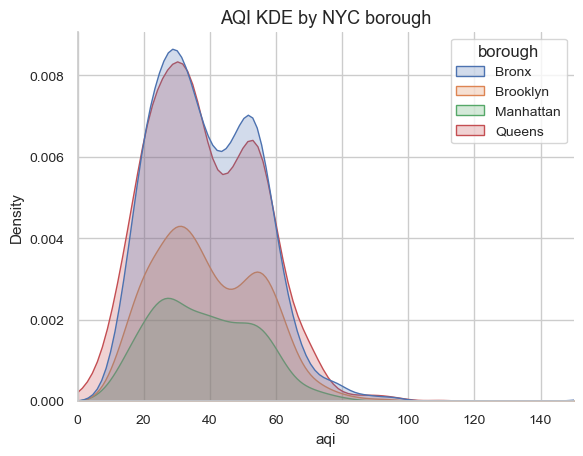

In [47]:
# KDE of AQI by borough

sns.kdeplot(data=eda_daily_pm25_ny, x='aqi', hue='borough', fill=True)
plt.title('AQI KDE by NYC borough')
plt.xlim(0, 150)
plt.show()

In [48]:
# More detail on above split

eda_daily_pm25_ny.groupby('borough')['aqi'].describe().reset_index().sort_values('borough')

,borough,count,mean,std,min,25%,50%,75%,max
0,Bronx,1792.0,39.227632,17.120596,8.0,27.0,37.0,51.0625,252.5
1,Brooklyn,909.0,39.246791,16.382776,9.0,27.0,36.5,52.0000,153.0
2,Manhattan,550.0,38.489091,16.517492,9.0,26.0,37.0,50.5000,154.0
3,Queens,1813.0,38.513697,18.291239,0.0,25.5,36.0,51.5000,277.5


In [49]:
# KDE of AQI by season 

# Group observations into seasons 
eda_daily_pm25_ny['month'] = eda_daily_pm25_ny['date_local'].dt.month

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
eda_daily_pm25_ny['season'] = eda_daily_pm25_ny['month'].apply(assign_season)
eda_daily_pm25_ny.head()

,borough,date_local,aqi,month,season
0,Bronx,2020-01-01,18.50,1,Winter
1,Bronx,2020-01-02,53.50,1,Winter
2,Bronx,2020-01-03,61.50,1,Winter
3,Bronx,2020-01-04,55.75,1,Winter
4,Bronx,2020-01-05,12.50,1,Winter


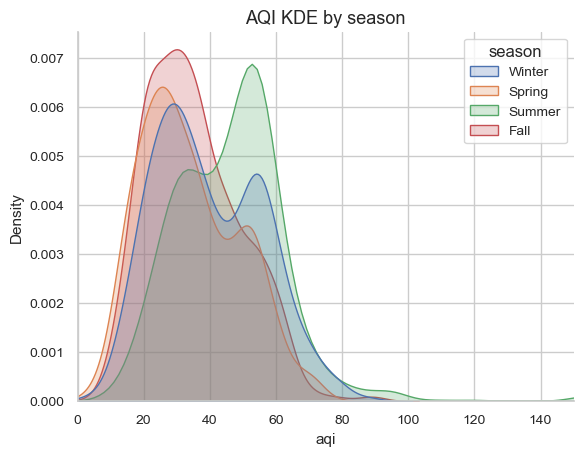

In [50]:
# Compare seasonal AQI distributions 

sns.kdeplot(data=eda_daily_pm25_ny, x='aqi', hue='season', fill=True)
plt.title('AQI KDE by season')
plt.xlim(0, 150)
plt.show()

In [51]:
eda_daily_pm25_ny.groupby('season')['aqi'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
Fall,1328.0,34.932919,14.276709,3.0,24.000000,33.0,44.8125,93.0
Spring,1195.0,33.881729,14.941195,0.0,22.416667,31.5,45.5000,78.5
Summer,1273.0,47.039670,20.162243,9.0,34.000000,47.5,55.5000,277.5
Winter,1268.0,39.593454,16.267856,1.0,26.500000,37.0,53.3750,89.5


In [52]:
# Calculate lowess smoothed curves for time series plotting

def calculate_lowess(group):
    for frac in [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25]:
        smoothed = lowess(endog=group['aqi'], exog=group['date_local'], frac=frac, return_sorted=False) 
        col_name = f'lowess_smoothed_{int(frac * 100):02d}'
        group[col_name] = pd.Series(smoothed, index=group.index)
    return group 

eda_daily_pm25_ny = eda_daily_pm25_ny.groupby('borough').apply(calculate_lowess).reset_index(drop=True)
eda_daily_pm25_ny.head()

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/2447313875.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eda_daily_pm25_ny = eda_daily_pm25_ny.groupby('borough').apply(calculate_lowess).reset_index(drop=True)


,borough,date_local,aqi,month,season,lowess_smoothed_01,lowess_smoothed_02,lowess_smoothed_05,lowess_smoothed_10,lowess_smoothed_15,lowess_smoothed_20,lowess_smoothed_25
0,Bronx,2020-01-01,18.50,1,Winter,45.760130,42.885891,41.688464,44.044937,38.266529,36.740699,37.017010
1,Bronx,2020-01-02,53.50,1,Winter,45.150646,42.721851,41.677649,43.931229,38.235509,36.743365,37.021913
2,Bronx,2020-01-03,61.50,1,Winter,44.575035,42.560842,41.666820,43.817440,38.204778,36.746149,37.026849
3,Bronx,2020-01-04,55.75,1,Winter,44.082561,42.403684,41.655979,43.703572,38.174340,36.749052,37.031820
4,Bronx,2020-01-05,12.50,1,Winter,43.685641,42.250349,41.645073,43.589625,38.144199,36.752073,37.036824


<Figure size 1500x500 with 0 Axes>

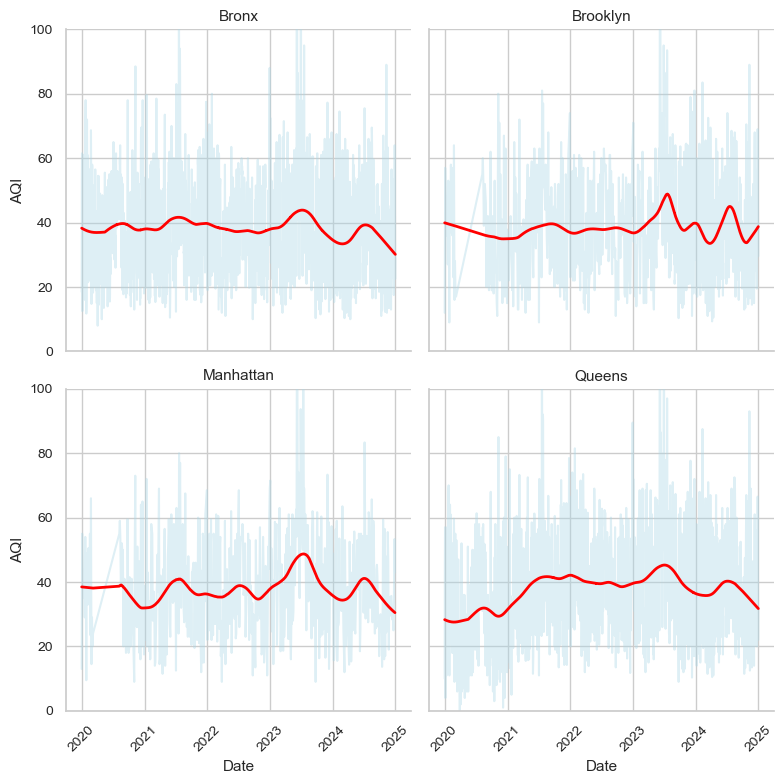

In [53]:
# Plot time series 

plt.figure(figsize=(15, 5))

g = sns.FacetGrid(
    # eda_daily_pm25_ny[eda_daily_pm25_ny['date_local']>='2021-01-01'],
    eda_daily_pm25_ny,
    col='borough',
    col_wrap=2,
    height=4,
    sharey=True,
    sharex=True
)

def plot_aqi_and_lowess(data, color, **kwargs):
    plt.plot(data['date_local'], data['aqi'], color='lightblue', alpha=0.4, label='AQI')
    plt.plot(data['date_local'], data['lowess_smoothed_15'], color='red', linewidth=2, label='LOWESS')
    plt.xticks(rotation=45)
    plt.legend()

g.map_dataframe(plot_aqi_and_lowess)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Date", "AQI")
g.tight_layout()

plt.ylim(0, 100)

plt.show()

In [54]:
# How much data per borough per year
eda_daily_pm25_ny['year'] = eda_daily_pm25_ny['date_local'].dt.year
eda_daily_pm25_ny.groupby(['borough', 'year'])['date_local'].nunique().reset_index()

,borough,year,date_local
0,Bronx,2020,365
1,Bronx,2021,365
2,Bronx,2022,340
3,Bronx,2023,365
4,Bronx,2024,366
5,Brooklyn,2020,72
6,Brooklyn,2021,114
7,Brooklyn,2022,117
8,Brooklyn,2023,241
9,Brooklyn,2024,366


## Health outcome data

In [55]:
# Create copy of health outcome data for EDA

eda_health = health.copy()
eda_health.head()

,zip,date,count,complaint,borough
0,10451,2023-01-23,4,asthma,Bronx
1,10451,2023-01-24,1,asthma,Bronx
2,10451,2023-01-25,0,asthma,Bronx
3,10451,2023-01-26,2,asthma,Bronx
4,10451,2023-01-27,2,asthma,Bronx


In [56]:
# General EDA 

eda_health.shape # ~50k rows 
eda_health.groupby('borough')['date'].nunique() # 402 days of data for each borough 
eda_health.groupby('zip')['date'].nunique() # 402 days of data for each zip 
eda_health.columns

Index(['zip', 'date', 'count', 'complaint', 'borough'], dtype='object')

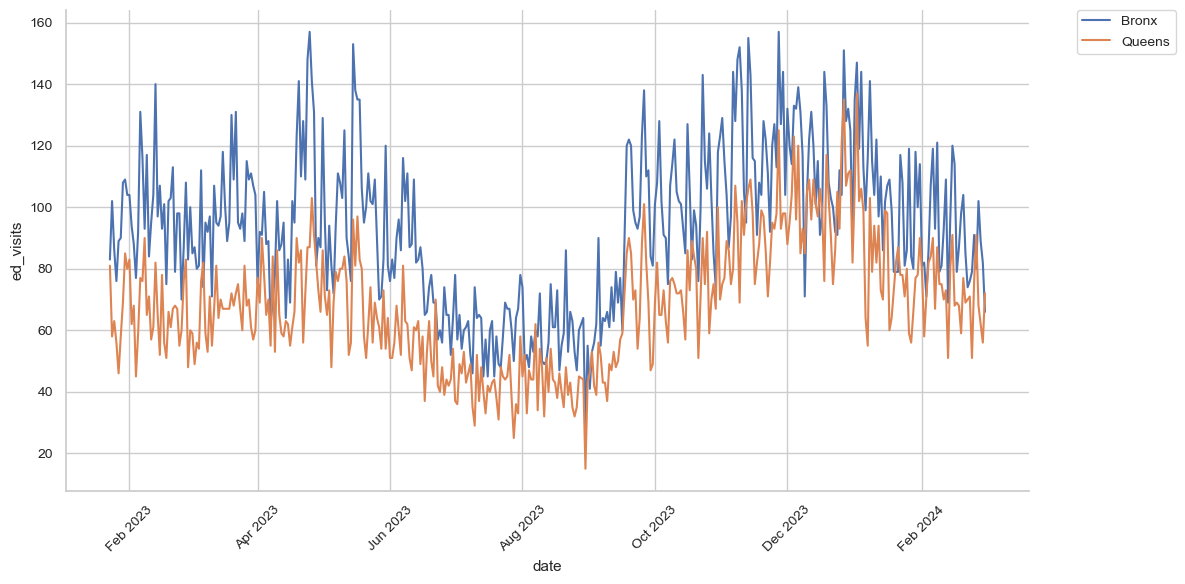

In [57]:
# Time series of health outcome data 

eda_health_daily_topline = eda_health.groupby(['borough', 'date'])['count'].sum().reset_index()
eda_health_daily_topline.rename(columns={'count': 'ed_visits'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=eda_health_daily_topline, x='date', y='ed_visits', hue='borough')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/1313032210.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eda_health_daily_topline = eda_health_daily_topline.groupby('borough').apply(calculate_lowess_health).reset_index(drop=True)


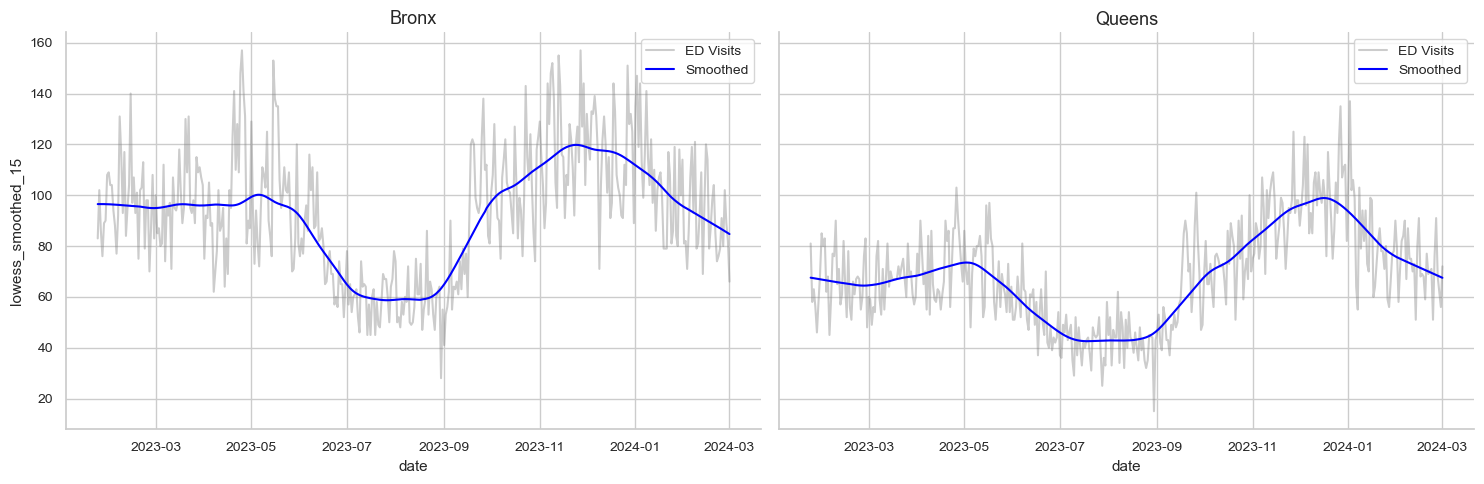

In [58]:
# With smoothed data

def calculate_lowess_health(group):
    for frac in [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25]:
        smoothed = lowess(endog=group['ed_visits'], exog=group['date'], frac=frac, return_sorted=False) 
        col_name = f'lowess_smoothed_{int(frac * 100):02d}'
        group[col_name] = pd.Series(smoothed, index=group.index)
    return group 

eda_health_daily_topline = eda_health_daily_topline.groupby('borough').apply(calculate_lowess_health).reset_index(drop=True)

smooth_col = 'lowess_smoothed_15'
g = sns.FacetGrid(eda_health_daily_topline, col="borough", height=5, aspect=1.5, sharey=True)
g.map(sns.lineplot, "date", "ed_visits", label="ED Visits", color='gray', alpha=0.4)
g.map(sns.lineplot, "date", smooth_col, label="Smoothed", color='blue')

for ax in g.axes.flat:
    ax.legend()
    ax.set_title(ax.get_title().replace("borough = ", ""))

plt.tight_layout()
plt.show()

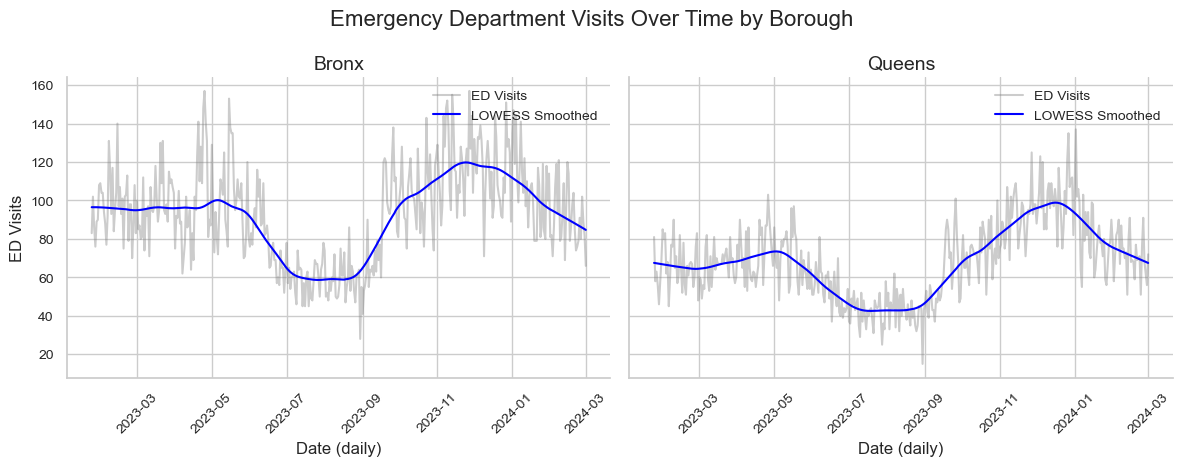

In [86]:
# Apply consistent visual theme
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.autolayout': False
})

# Set column to plot
smooth_col = 'lowess_smoothed_15'

# Faceted plot by borough
g = sns.FacetGrid(
    eda_health_daily_topline, 
    col="borough", 
    height=4, 
    aspect=1.5, 
    sharey=True,
    legend_out=False
)

# Plot raw and smoothed lines
g.map(sns.lineplot, "date", "ed_visits", color='gray', alpha=0.4, label="ED Visits")
g.map(sns.lineplot, "date", smooth_col, color='blue', label="LOWESS Smoothed")

# Format each subplot
for ax in g.axes.flat:
    ax.legend(loc='upper right', frameon=False)
    ax.set_title(ax.get_title().replace("borough = ", ""))
    ax.tick_params(axis='x', rotation=45)

# Axis labels and layout
g.set_axis_labels("Date (daily)", "ED Visits")
g.fig.suptitle("Emergency Department Visits Over Time by Borough", fontsize=16, y=1.08)
g.fig.subplots_adjust(top=0.91, hspace=0.4)

plt.show()

In [ ]:
# Some topline stats

eda_health_daily_topline.groupby('borough')['ed_visits'].mean() # Daily avg. ED visits: Bronx 93 vs. Queens 69 

# 8 of the top 10 highest daily avg. count at zipcode level is from Bronx
eda_health.groupby(['borough', 'zip'])['count'].mean().sort_values(ascending=False).reset_index()

,borough,zip,count
0,Bronx,10467,4.132005
1,Bronx,10457,3.702366
2,Bronx,10456,3.698630
3,Bronx,10466,3.082192
4,Bronx,10453,3.034869
...,...,...,...
57,Queens,11361,0.266501
58,Queens,11103,0.252802
59,Queens,11426,0.231631
60,Queens,11364,0.122042


# Prepare the data 

## Environmental data

Having successfully gathered borough-level daily AQI data and conducted preliminary exploratory data analysis (EDA), we now proceed to construct the final dataset for causal analysis.

As observed earlier, the availability of AQI data varies across boroughs. Specifically, Brooklyn and Manhattan exhibit AQI measurements at three-day intervals, whereas the Bronx and Queens maintain the desired daily frequency. Consequently, our final analysis will focus exclusively on the Bronx and Queens.

Preparing the final environmental dataset involves minimal processing beyond filtering for the appropriate boroughs and ensuring the correct data types for each column.

In [60]:
# Create final dataset for AQI

aqi = final_daily_pm25_ny[final_daily_pm25_ny['borough'].isin(['Bronx', 'Queens'])].copy()
aqi = aqi.sort_values(['borough', 'date_local'])
# aqi['month'] = aqi['date_local'].dt.month
# aqi['year'] = aqi['date_local'].dt.year
# aqi['season'] = aqi['month'].apply(assign_season)
aqi.rename(columns={'date_local': 'date'}, inplace=True)

# Linear interpolation to fill missing gaps
aqi = aqi.set_index('date')
aqi['aqi'] = aqi.groupby('borough')['aqi'].transform(lambda x: x.interpolate(method='time'))
aqi = aqi.reset_index()
aqi.head(10)

,date,borough,aqi
0,2020-01-01,Bronx,18.50
1,2020-01-02,Bronx,53.50
2,2020-01-03,Bronx,61.50
3,2020-01-04,Bronx,55.75
4,2020-01-05,Bronx,12.50
5,2020-01-06,Bronx,46.50
6,2020-01-07,Bronx,43.50
7,2020-01-08,Bronx,43.00
8,2020-01-09,Bronx,23.50
9,2020-01-10,Bronx,39.75


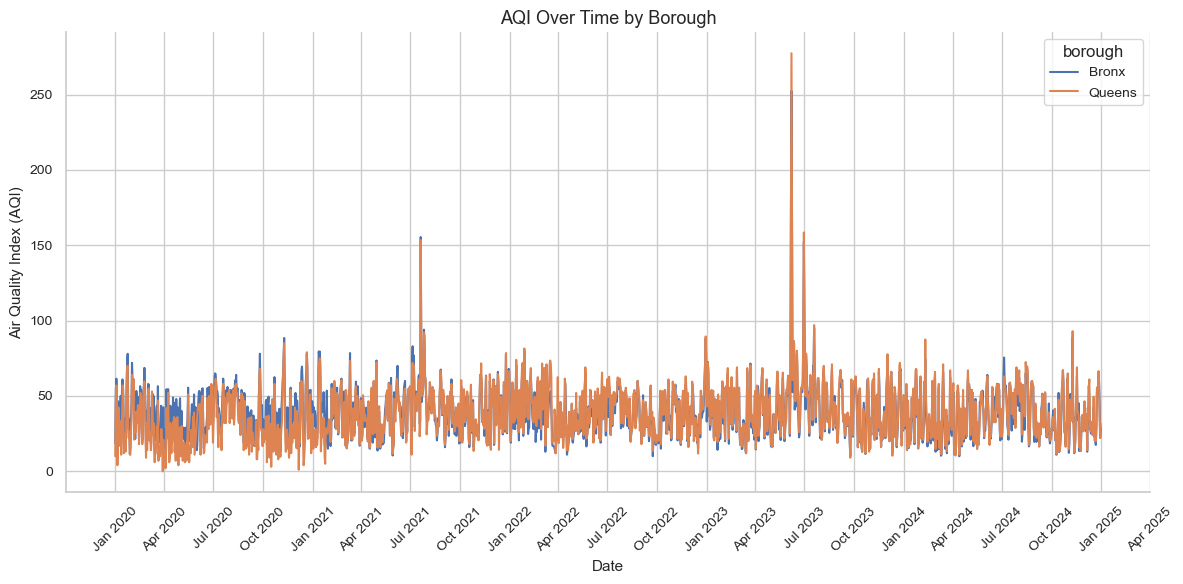

In [61]:
# Plot final data 

plt.figure(figsize=(12, 6))
sns.lineplot(data=aqi, x='date', y='aqi', hue='borough')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.title('AQI Over Time by Borough')
plt.xlabel('Date')
plt.ylabel('Air Quality Index (AQI)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Health outcome data

Using AQI data to identify historical natural experiments allowed us to select a specific timeframe for which we want to gather health outcome data. Although this doesn't necessarily follow the order of this notebook, that's the order I did things. 

Using the NYC Syndromic Surveillance dashboard, I was able to download the health outcome data for the specific dates that were determined. It's available at the zipcode level, split by chief complaint (asthma vs. nonspecific respiratory symptom). However, for our use case, we do not need it at the zipcode level. Rather, we just need total daily ED visits (asthma and respiratory combined) at the borough level.

In [62]:
# Prepare final dataset for health outcomes 

health_outcomes = health.copy()
health_outcomes = health_outcomes.groupby(['date', 'borough'])['count'].sum().reset_index()
health_outcomes.rename(columns={'count': 'ed_visits'}, inplace=True)

# Add missing dates
health_outcomes.loc[len(health_outcomes)] = ['2023-08-28', 'Bronx', np.nan]
health_outcomes.loc[len(health_outcomes)] = ['2023-08-28', 'Queens', np.nan]
health_outcomes.loc[len(health_outcomes)] = ['2023-09-17', 'Bronx', np.nan]
health_outcomes.loc[len(health_outcomes)] = ['2023-09-17', 'Queens', np.nan]

health_outcomes['date'] = pd.to_datetime(health_outcomes['date'])

# Linear interpolation to fill missing gaps: [Timestamp('2023-08-28 00:00:00'), Timestamp('2023-09-17 00:00:00')] 
health_outcomes = health_outcomes.set_index('date')
health_outcomes['ed_visits'] = health_outcomes.groupby('borough')['ed_visits'].transform(lambda x: x.interpolate(method='time'))
health_outcomes = health_outcomes.reset_index()
health_outcomes.head()

health_outcomes[health_outcomes['date'].isin(['2023-09-17', '2023-08-28'])]

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/4275166963.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  health_outcomes[health_outcomes['date'].isin(['2023-09-17', '2023-08-28'])]


,date,borough,ed_visits
804,2023-08-28,Bronx,62.0
805,2023-08-28,Queens,44.5
806,2023-09-17,Bronx,90.0
807,2023-09-17,Queens,72.0


# Analysis

## Identifying natural experiments

With the cleaned AQI data for both the Bronx and Queens prepared, the next step is to identify time periods where the AQI levels between these two boroughs diverge significantly, enough to create the conditions for a natural experiment.

The goal of identifying a natural experiment is to approximate the structure of a geo experiment. Specifically, when the AQI in one borough rises markedly above that of the other, we can treat this divergence as a point-in-time intervention, analogous to the launch of a marketing campaign in select geographic regions. By treating AQI variation as the intervention, we can then examine health outcome data to assess whether a causal relationship exists between air quality and health impacts.

To begin, I will normalize the AQI values for each borough using Z-scores. Next, I will identify days when there is a pronounced spike in the normalized AQI (e.g., exceeding 2 standard deviations) in one borough, while the other borough maintains its baseline trend. Ideally, this spike or discrepancy should persist for several consecutive days. Once such events are identified, we can align them with corresponding dates in the health outcome data to analyze potential causal effects.

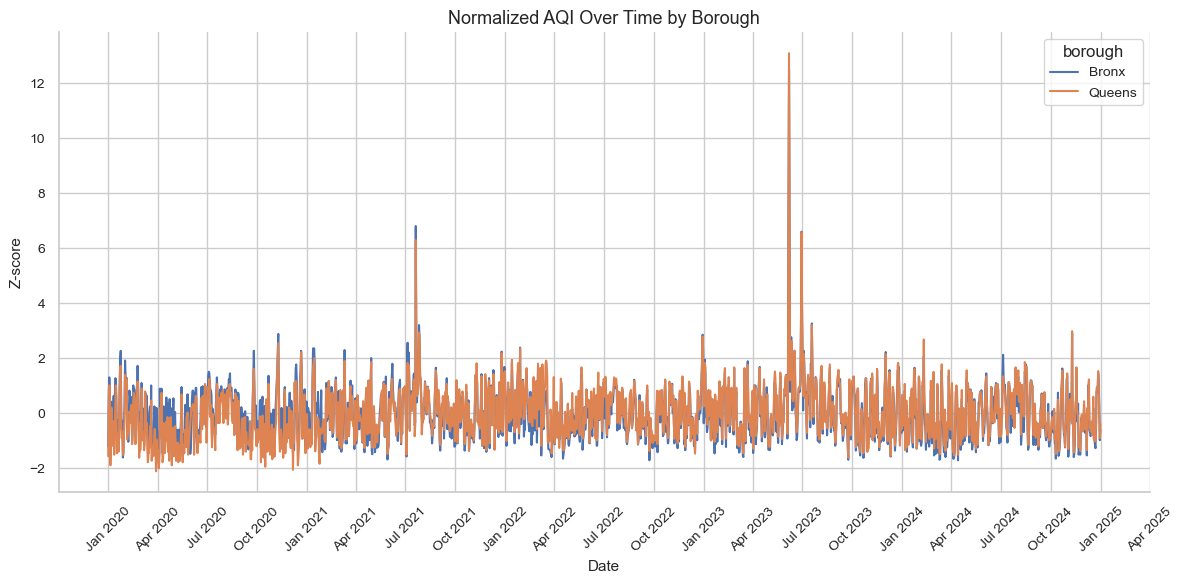

In [63]:
# Normalize AQI values 

aqi['z_local'] = aqi.groupby('borough')['aqi'].transform(lambda x: (x - x.mean()) / x.std())
aqi['z_global'] = (aqi['aqi'] - aqi['aqi'].mean()) / aqi['aqi'].std()

# Plot normalized values
plt.figure(figsize=(12, 6))
sns.lineplot(data=aqi, x='date', y='z_local', hue='borough')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.title('Normalized AQI Over Time by Borough')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [64]:
# Identify candidate days 

daily_spread = aqi.groupby('date').apply(lambda x: x['z_local'].max() - x['z_local'].min())
daily_spread = daily_spread.reset_index(name='range_z_score')

daily_spread.sort_values('range_z_score', ascending=False)

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/2941781751.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_spread = aqi.groupby('date').apply(lambda x: x['z_local'].max() - x['z_local'].min())


,date,range_z_score
796,2022-03-07,1.770620
293,2020-10-20,1.735802
359,2020-12-25,1.535562
358,2020-12-24,1.437316
10,2020-01-11,1.426068
...,...,...
148,2020-05-28,0.000000
833,2022-04-13,0.000000
203,2020-07-22,0.000000
394,2021-01-29,0.000000


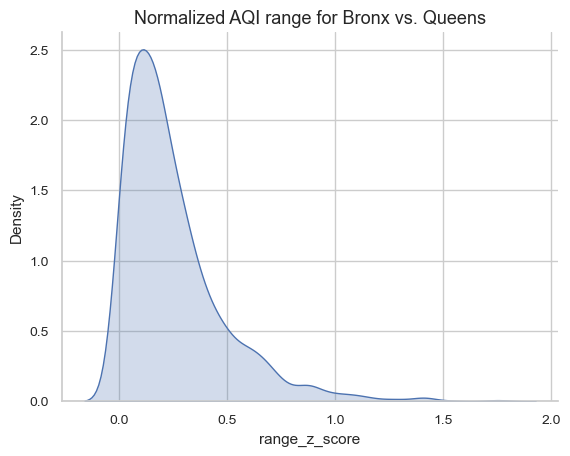

In [65]:
# Plot distribution of Z-score range

sns.kdeplot(data=daily_spread, x='range_z_score', fill=True)
plt.title('Normalized AQI range for Bronx vs. Queens')
plt.show()

In [66]:
# Plot time series range to inspect air differences

def plot_aqi_range(metric, start_date, end_date, experiment_start_date, experiment_end_date):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=aqi[aqi['date'].between(start_date, end_date)], x='date', y=metric, hue='borough')

    plt.axvline(pd.to_datetime(experiment_start_date), color='red', linestyle='--', label='Divergence')
    plt.axvline(pd.to_datetime(experiment_end_date), color='red', linestyle='--', label='Divergence')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# plot_aqi_range('aqi_filled', '2020-10-01', '2020-12-31', '2020-10-20')

In [67]:
# Identify longer periods of sustained AQI gap between boroughs
threshold = 0.50
daily_spread['is_divergent'] = daily_spread['range_z_score'] > threshold

daily_spread['group'] = (daily_spread['is_divergent']!=daily_spread['is_divergent'].shift()).cumsum()

sustained_periods = daily_spread[daily_spread['is_divergent']].groupby('group').filter(lambda x: len(x) >= 3)
sustained_periods 

,date,range_z_score,is_divergent,group
10,2020-01-11,1.426068,True,6
11,2020-01-12,0.763114,True,6
12,2020-01-13,1.084464,True,6
13,2020-01-14,0.974590,True,6
37,2020-02-07,0.514811,True,14
...,...,...,...,...
383,2021-01-18,0.893977,True,172
384,2021-01-19,0.533246,True,172
1501,2024-02-10,0.617200,True,274
1502,2024-02-11,0.605938,True,274


In [68]:
# Find longest periods of sustained AQI gap 

sustained_periods.groupby('group')['date'].agg(['min', len]).sort_values('len', ascending=False).reset_index()
sustained_periods[sustained_periods['group']==274]

,date,range_z_score,is_divergent,group
1501,2024-02-10,0.617200,True,274
1502,2024-02-11,0.605938,True,274
1503,2024-02-12,0.656057,True,274


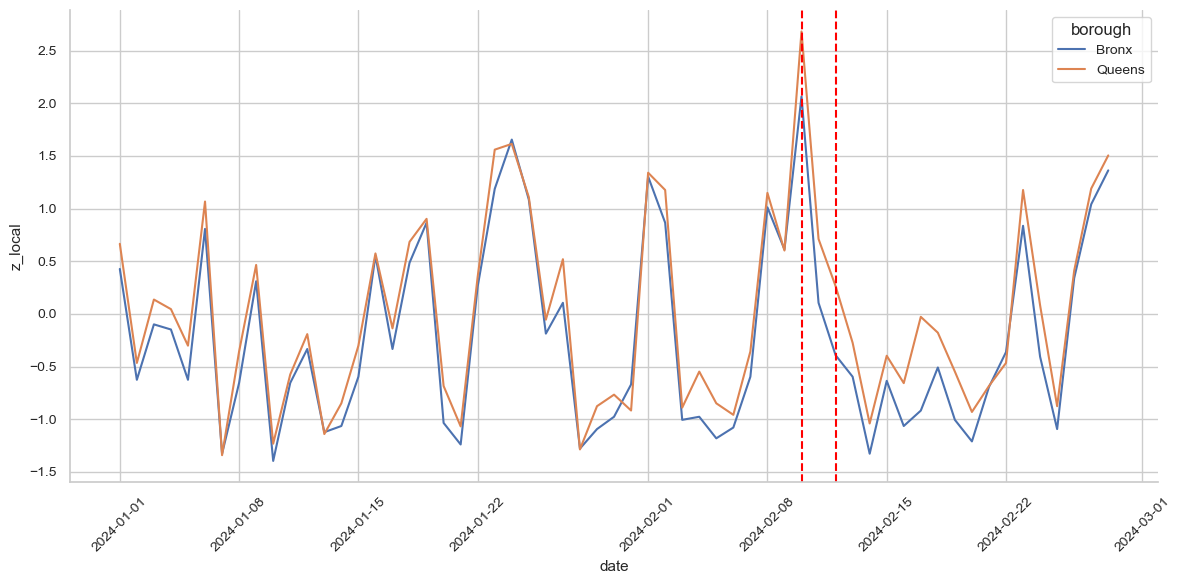

In [69]:
plot_aqi_range('z_local', '2024-01-01', '2024-02-28', '2024-02-10', '2024-02-12')

It's becoming increasingly clear that our AQI time series data does not follow a smooth progression. Moreover, AQI trends across boroughs tend to closely mirror one another, leaving little room for sustained deviations that might serve as natural experiments for geo-experimental analysis.

To quantify "sustained deviation" between boroughs, I've defined a metric: the daily range of Z-scores (maximum minus minimum) between the two boroughs. I've chosen, somewhat arbitrarily, to classify a day as "divergent" if the Z-score difference exceeds 0.5.

Using this criterion, I identified a limited number of divergent periods (n = 16). The longest such stretch spans 7 consecutive days, beginning on 2020-03-16. However, this date coincides with the onset of the COVID-19 outbreak in the U.S., a major external factor that cannot be ignored, particularly when analyzing health outcomes such as asthma attacks or respiratory symptoms. Several other divergent periods also overlap with COVID-19 peaks.

To minimize confounding effects from the pandemic, a three-day period starting on 2024-02-10 appears promising. While COVID-19 was still circulating at that time, it was no longer at early-pandemic levels.

__Geo experiment testing parameters:__
- **Start date:** February 10, 2024  
- **End date:** February 12, 2024  
- **Pre-test duration:** 365 days (2023-02-09 to 2024-02-09)
- **Cooldown duration:** 7 days (2024-02-13 to 2024-02-19)

We'll begin with a 365-day pre-test window to construct robust counterfactual models for both air quality and associated health outcomes, along with a 7-day cooldown window to capture potential lagging effects.

In [70]:
# Filter final datasets to match experiment dates

aqi_final = aqi[aqi['date'].between('2023-02-09', '2024-02-19')].reset_index(drop=True)
aqi_final.drop(columns=['z_local', 'z_global'], inplace=True)
aqi_final = aqi_final.pivot(index='date', columns='borough', values='aqi')
aqi_final.info()

health_outcomes_final = health_outcomes[health_outcomes['date'].between('2023-02-09', '2024-02-19')].reset_index(drop=True)
health_outcomes_final = health_outcomes_final.pivot(index='date', columns='borough', values='ed_visits')
health_outcomes_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2023-02-09 to 2024-02-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bronx   376 non-null    float64
 1   Queens  376 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2023-02-09 to 2024-02-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bronx   376 non-null    float64
 1   Queens  376 non-null    float64
dtypes: float64(2)
memory usage: 8.8 KB


In [71]:
# Missing dates in health outcome data
# FIXED, NO MORE MISSING DATES

# missing_dates = set(aqi_final['date'].unique()) - set(health_outcomes_final['date'].unique())
# print(sorted(missing_dates))

## Modeling the pretest relationship

The objective of this step is to fit two linear regression models using data from a 365-day pretest window. In these models, air quality and health outcome data from Queens serve as the dependent variables, while corresponding data from the Bronx are used as the independent variables. The fitted models will be used to generate counterfactual predictions for Queens, which is treated as the intervention group due to its elevated AQI levels relative to the Bronx during the period of February 10–12, 2024.

In [72]:
# Join data for modeling purposes 

data_final = aqi_final.join(health_outcomes_final, lsuffix='_aqi', rsuffix='_ed')
data_final.columns = [col.lower() for col in data_final.columns]
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376 entries, 2023-02-09 to 2024-02-19
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bronx_aqi   376 non-null    float64
 1   queens_aqi  376 non-null    float64
 2   bronx_ed    376 non-null    float64
 3   queens_ed   376 non-null    float64
dtypes: float64(4)
memory usage: 14.7 KB


In [73]:
import statsmodels.api as sm 

pre = data_final[data_final.index < '2024-02-10']

# Model A: AQI 
X_aqi = sm.add_constant(pre['bronx_aqi'])
y_aqi = pre['queens_aqi']
model_aqi = sm.OLS(y_aqi, X_aqi).fit()
print(model_aqi.summary())

                            OLS Regression Results                            
Dep. Variable:             queens_aqi   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.631e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):          2.23e-304
Time:                        23:14:28   Log-Likelihood:                -982.93
No. Observations:                 366   AIC:                             1970.
Df Residuals:                     364   BIC:                             1978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3103      0.391     -0.794      0.4

In [74]:
# Model B: health outcomes 
X_ed = sm.add_constant(pre['bronx_ed'])
y_ed = pre['queens_ed']
model_ed = sm.OLS(y_ed, X_ed).fit()
print(model_ed.summary())

                            OLS Regression Results                            
Dep. Variable:              queens_ed   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     554.8
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           3.48e-75
Time:                        23:14:28   Log-Likelihood:                -1467.9
No. Observations:                 366   AIC:                             2940.
Df Residuals:                     364   BIC:                             2948.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1533      2.576      3.941      0.0

## Generating counterfactual predictions

The time series data for both AQI and health outcomes exhibit strong correlations between Queens and the Bronx, with R-squared values of 0.98 and 0.60, respectively, for the two models. Given the large sample size, the F-test p-values associated with these R-squared values are statistically significant for both models. This indicates that our counterfactual predictions should provide reliable estimates of what would have occurred in the absence of the "intervention"—in this case, a natural deviation in AQI between the Bronx and Queens during the test period.

The goal is to generate counterfactual predictions for the pretest, test, and cooldown periods. For the test and cooldown periods, we are interested in the differences between observed and counterfactual values for Queens. During the pretest period, however, we expect this difference to be minimal and centered around zero, serving as a validation check for the model.


In [75]:
data_final.index.min()

Timestamp('2023-02-09 00:00:00')

In [77]:
# Generate counterfactuals for aqi and ed (emergency dept visits)

# aqi counterfactuals
X_aqi = sm.add_constant(data_final['bronx_aqi'])
data_final['predicted_queens_aqi'] = model_aqi.predict(X_aqi)

# ed counterfactuals
X_ed = sm.add_constant(data_final['bronx_ed'])
data_final['predicted_queens_ed'] = model_ed.predict(X_ed)

data_final.head()

,bronx_aqi,queens_aqi,bronx_ed,queens_ed,predicted_queens_aqi,predicted_queens_ed
date,,,,,,
2023-02-09,65.00,68.50,117.0,65.0,67.468799,83.247152
2023-02-10,37.50,40.00,84.0,71.0,38.793044,62.630938
2023-02-11,18.25,21.75,95.0,57.0,18.720015,69.503009
2023-02-12,52.00,55.50,104.0,61.0,53.912988,75.125613
2023-02-13,35.50,41.50,140.0,82.0,36.707534,97.616029


## Estimate effects 

In [91]:
# # AQI time based regression visual

# # Pointwise effect 
# data_final['effect_aqi'] = data_final['queens_aqi'] - data_final['predicted_queens_aqi']

# # Compute std of pre-period residuals 
# post_mask = data_final.index >= '2024-02-10'
# pre = data_final[data_final.index < '2024-02-10']
# resid_std = (pre['queens_aqi'] - pre['predicted_queens_aqi']).std()

# # Counterfactual CI (top panel)
# data_final['cf_upper'] = data_final['predicted_queens_aqi'] + 1.96 * resid_std
# data_final['cf_lower'] = data_final['predicted_queens_aqi'] - 1.96 * resid_std
# data_final.loc[~post_mask, ['cf_upper', 'cf_lower']] = np.nan

# # Pointwise CI (middle panel)
# data_final['upper_diff_aqi'] = data_final['effect_aqi'] + 1.96 * resid_std
# data_final['lower_diff_aqi'] = data_final['effect_aqi'] - 1.96 * resid_std
# data_final.loc[~post_mask, ['upper_diff_aqi', 'lower_diff_aqi']] = np.nan

# # Cumulative effect CI (bottom panel)
# data_final['post_effect_aqi'] = 0
# data_final.loc[post_mask, 'post_effect_aqi'] = data_final.loc[post_mask, 'effect_aqi']
# data_final['cumulative_effect_aqi'] = data_final['post_effect_aqi'].cumsum()

# n_post_days = np.arange(len(data_final))
# n_post_days[~post_mask] = 0
# n_post_days[post_mask] = np.arange(1, post_mask.sum() + 1)

# data_final['upper_cum_aqi'] = data_final['cumulative_effect_aqi'] + 1.96 * resid_std * np.sqrt(n_post_days)
# data_final['lower_cum_aqi'] = data_final['cumulative_effect_aqi'] - 1.96 * resid_std * np.sqrt(n_post_days)
# data_final.loc[~post_mask, ['upper_cum_aqi', 'lower_cum_aqi']] = np.nan

# # Plotting
# fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# # Panel 1: Observed vs. Counterfactual
# axs[0].plot(data_final.index, data_final['queens_aqi'], label='Observed', color='darkred')
# axs[0].plot(data_final.index, data_final['predicted_queens_aqi'], label='Predicted', color='navy')
# axs[0].fill_between(data_final.index, data_final['cf_lower'], data_final['cf_upper'], color='navy', alpha=0.2)
# axs[0].set_ylabel('AQI')
# axs[0].set_title('Observed & Counterfactual AQI')
# axs[0].legend()

# # Panel 2: Pointwise Differences
# axs[1].plot(data_final.index, data_final['effect_aqi'], label='Pointwise Difference', color='blue')
# axs[1].fill_between(data_final.index, data_final['lower_diff_aqi'], data_final['upper_diff_aqi'], color='blue', alpha=0.2)
# axs[1].set_ylabel('AQI Difference')
# axs[1].set_title('Pointwise Differences')

# # Panel 3: Cumulative Effect
# axs[2].plot(data_final.index, data_final['cumulative_effect_aqi'], label='Cumulative Effect', color='blue')
# axs[2].fill_between(data_final.index, data_final['lower_cum_aqi'], data_final['upper_cum_aqi'], color='blue', alpha=0.2)
# axs[2].set_ylabel('Cumulative AQI')
# axs[2].set_title('Cumulative Effect')
# axs[2].set_xlabel('Date')

# # Define key dates
# pretest_start = pd.to_datetime('2023-02-09')
# test_start = pd.to_datetime('2024-02-10')
# test_end = pd.to_datetime('2024-02-12')

# # Loop over panels to add vertical lines
# for ax in axs:
#     ax.axvline(pretest_start, color='gray', linestyle='--')
#     ax.axvline(test_start, color='black', linestyle='--')
#     ax.axvline(test_end, color='black', linestyle='--')

# # Add horizontal line to pointwise diff panel
# axs[1].axhline(0, color='gray', linestyle='--')

# # Update legend in top panel only
# axs[0].legend()

# plt.tight_layout()
# plt.show()

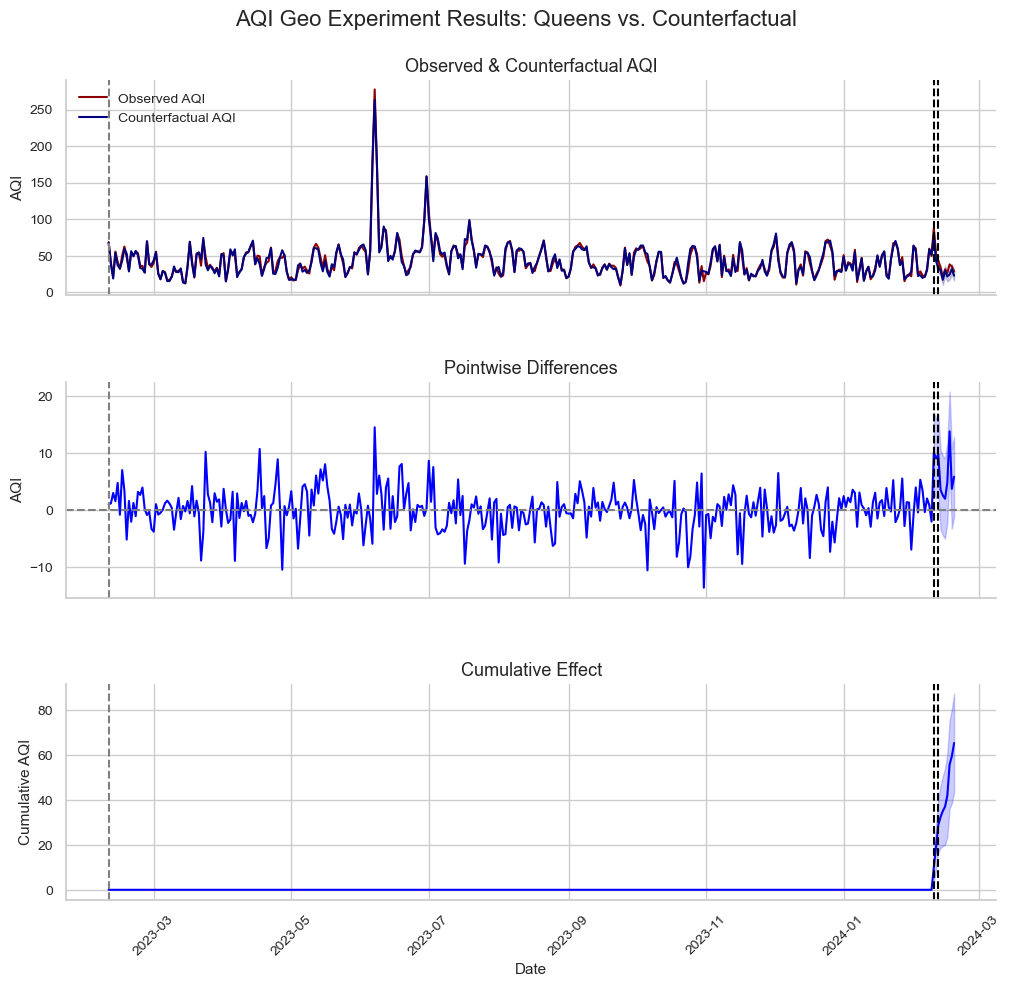

In [90]:
# Consistent style
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.autolayout': False
})

# Set up figure with 3 panels
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# --- Panel 1: Observed vs. Counterfactual ---
axs[0].plot(data_final.index, data_final['queens_aqi'], label='Observed AQI', color='darkred')
axs[0].plot(data_final.index, data_final['predicted_queens_aqi'], label='Counterfactual AQI', color='navy')
axs[0].fill_between(data_final.index, data_final['cf_lower'], data_final['cf_upper'], color='navy', alpha=0.2)
axs[0].set_ylabel('AQI')
axs[0].set_title('Observed & Counterfactual AQI')
axs[0].legend(loc='upper left', frameon=False)

# --- Panel 2: Pointwise Differences ---
axs[1].plot(data_final.index, data_final['effect_aqi'], label='Pointwise Difference', color='blue')
axs[1].fill_between(data_final.index, data_final['lower_diff_aqi'], data_final['upper_diff_aqi'], color='blue', alpha=0.2)
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_ylabel('AQI')
axs[1].set_title('Pointwise Differences')

# --- Panel 3: Cumulative Effect ---
axs[2].plot(data_final.index, data_final['cumulative_effect_aqi'], label='Cumulative Effect', color='blue')
axs[2].fill_between(data_final.index, data_final['lower_cum_aqi'], data_final['upper_cum_aqi'], color='blue', alpha=0.2)
axs[2].set_ylabel('Cumulative AQI')
axs[2].set_title('Cumulative Effect')
axs[2].set_xlabel('Date')

# --- Reference lines for test window ---
pretest_start = pd.to_datetime('2023-02-09')
test_start = pd.to_datetime('2024-02-10')
test_end = pd.to_datetime('2024-02-12')

for ax in axs:
    ax.axvline(pretest_start, color='gray', linestyle='--')
    ax.axvline(test_start, color='black', linestyle='--')
    ax.axvline(test_end, color='black', linestyle='--')
    ax.tick_params(axis='x', rotation=45)

# Add consistent supertitle and spacing
fig.suptitle("AQI Geo Experiment Results: Queens vs. Counterfactual", fontsize=16, y=1.0)
fig.subplots_adjust(top=0.93, hspace=0.4)

plt.show()


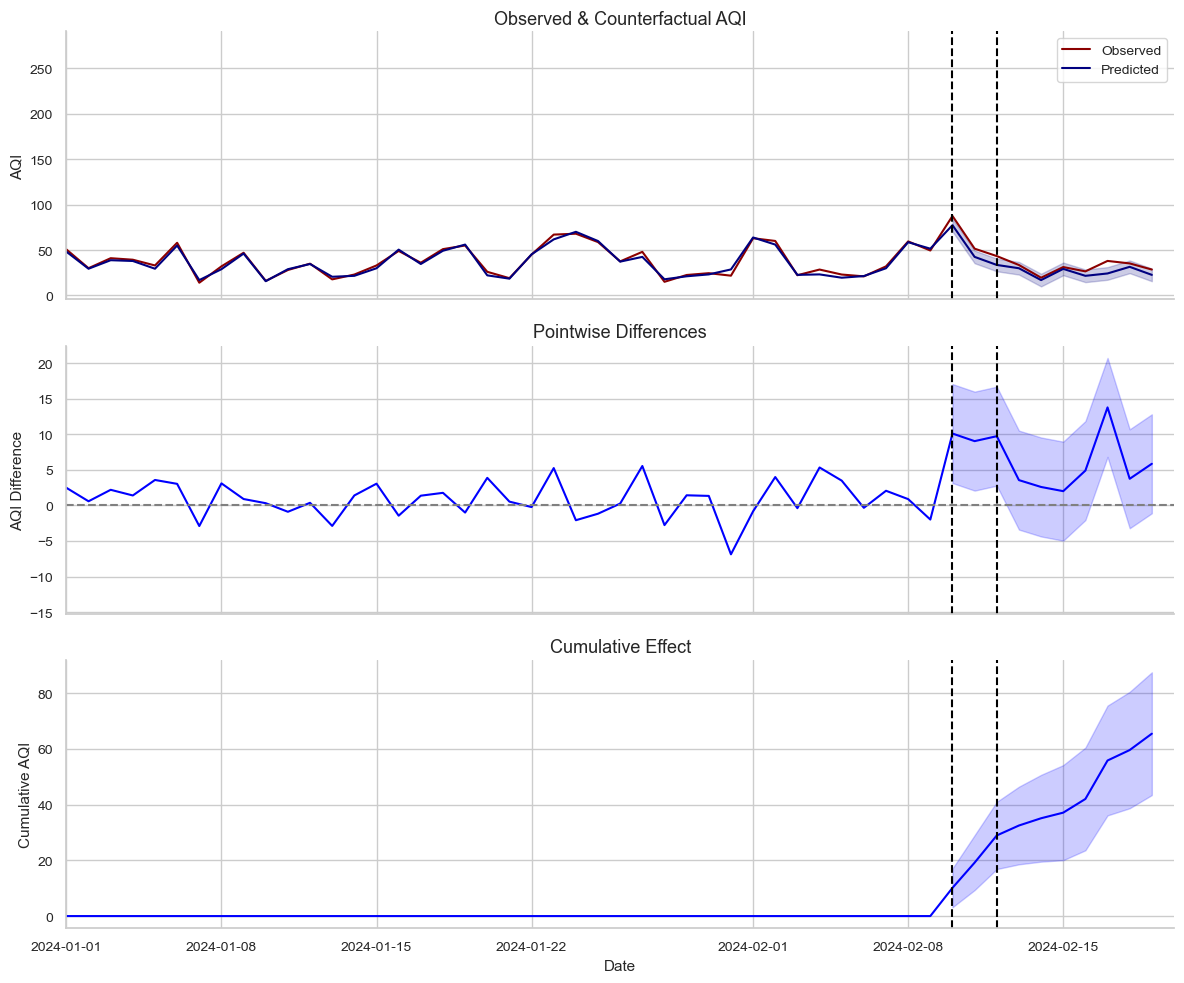

In [79]:
# Show shorter timeframe
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Panel 1: Observed vs. Counterfactual
axs[0].plot(data_final.index, data_final['queens_aqi'], label='Observed', color='darkred')
axs[0].plot(data_final.index, data_final['predicted_queens_aqi'], label='Predicted', color='navy')
axs[0].fill_between(data_final.index, data_final['cf_lower'], data_final['cf_upper'], color='navy', alpha=0.2)
axs[0].set_ylabel('AQI')
axs[0].set_title('Observed & Counterfactual AQI')
axs[0].legend()

# Panel 2: Pointwise Differences
axs[1].plot(data_final.index, data_final['effect_aqi'], label='Pointwise Difference', color='blue')
axs[1].fill_between(data_final.index, data_final['lower_diff_aqi'], data_final['upper_diff_aqi'], color='blue', alpha=0.2)
axs[1].set_ylabel('AQI Difference')
axs[1].set_title('Pointwise Differences')

# Panel 3: Cumulative Effect
axs[2].plot(data_final.index, data_final['cumulative_effect_aqi'], label='Cumulative Effect', color='blue')
axs[2].fill_between(data_final.index, data_final['lower_cum_aqi'], data_final['upper_cum_aqi'], color='blue', alpha=0.2)
axs[2].set_ylabel('Cumulative AQI')
axs[2].set_title('Cumulative Effect')
axs[2].set_xlabel('Date')

# Define key dates
pretest_start = pd.to_datetime('2023-02-09')
test_start = pd.to_datetime('2024-02-10')
test_end = pd.to_datetime('2024-02-12')

# Loop over panels to add vertical lines
for ax in axs:
    ax.axvline(pretest_start, color='gray', linestyle='--')
    ax.axvline(test_start, color='black', linestyle='--')
    ax.axvline(test_end, color='black', linestyle='--')

# Add horizontal line to pointwise diff panel
axs[1].axhline(0, color='gray', linestyle='--')

# Update legend in top panel only
axs[0].legend()

x_start = pd.to_datetime('2024-01-01')
x_end = pd.to_datetime('2024-02-20')

for ax in axs:
    ax.set_xlim([x_start, x_end])

plt.tight_layout()
plt.show()

/var/folders/6p/4gpqwsc104dfgn39c44h285m0000gn/T/ipykernel_36445/3846686756.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 14.24326324   1.74645813  -5.24928203  -2.25993164   9.87225685
   5.87864662 -13.37295082   9.49273076   3.49486068 -12.37721067]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_final.loc[post_mask, 'post_effect_ed'] = data_final.loc[post_mask, 'effect_ed']


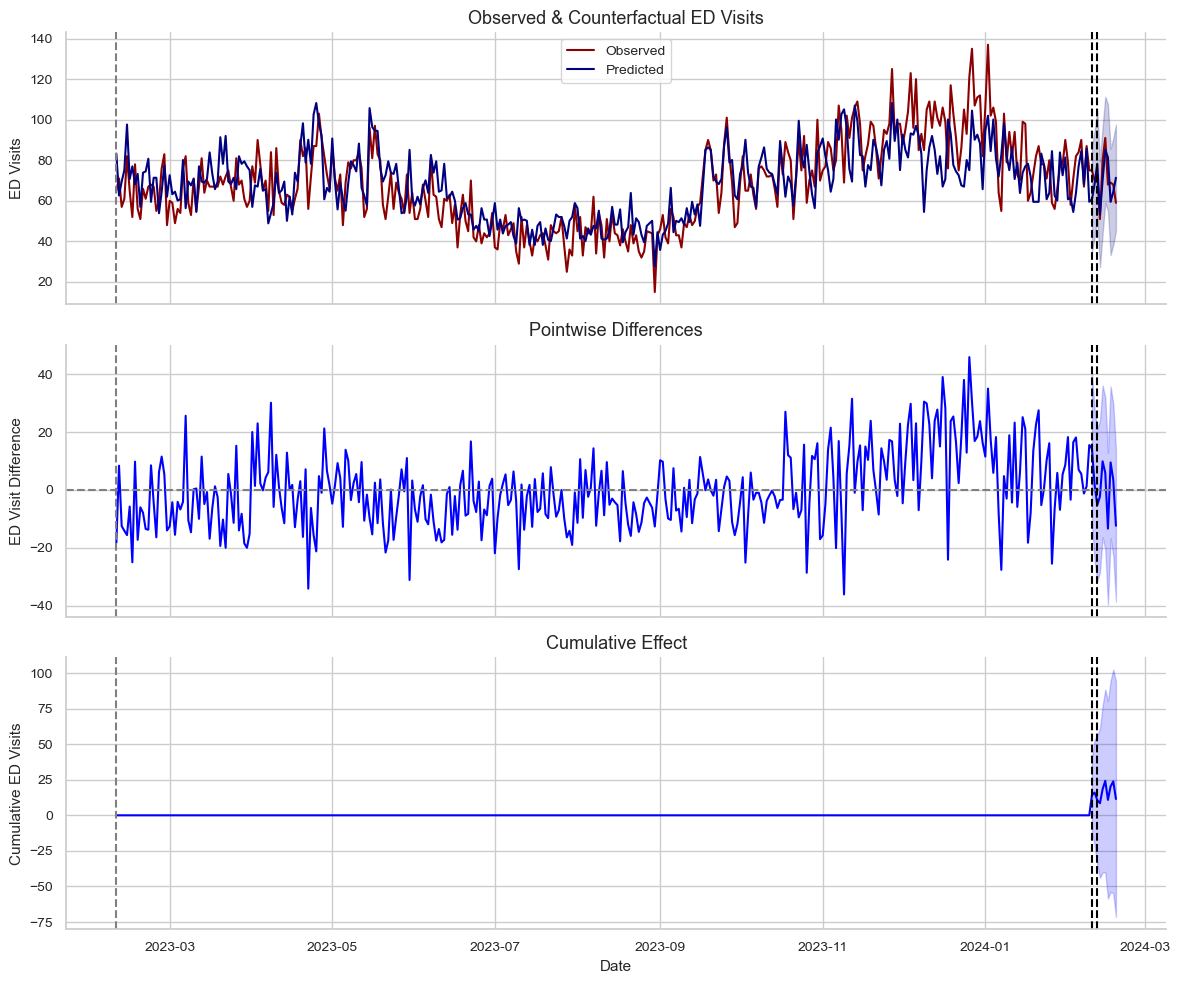

In [ ]:
# Replicate for health outcomes

# Pre-test residuals
post_mask = data_final.index >= '2024-02-10'
pre = data_final[data_final.index < '2024-02-10']
resid_std_ed = (pre['queens_ed'] - pre['predicted_queens_ed']).std()

# Pointwise effect
data_final['effect_ed'] = data_final['queens_ed'] - data_final['predicted_queens_ed']

# Counterfactual CI (upper panel)
data_final['cf_upper_ed'] = data_final['predicted_queens_ed'] + 1.96 * resid_std_ed
data_final['cf_lower_ed'] = data_final['predicted_queens_ed'] - 1.96 * resid_std_ed
data_final.loc[~post_mask, ['cf_upper_ed', 'cf_lower_ed']] = np.nan

# Pointwise difference CI (middle panel)
data_final['upper_diff_ed'] = data_final['effect_ed'] + 1.96 * resid_std_ed
data_final['lower_diff_ed'] = data_final['effect_ed'] - 1.96 * resid_std_ed
data_final.loc[~post_mask, ['upper_diff_ed', 'lower_diff_ed']] = np.nan

# Cumulative effect CI
data_final['post_effect_ed'] = 0
data_final.loc[post_mask, 'post_effect_ed'] = data_final.loc[post_mask, 'effect_ed']
data_final['cumulative_effect_ed'] = data_final['post_effect_ed'].cumsum()

n_post_days = np.arange(len(data_final))
n_post_days[~post_mask] = 0
n_post_days[post_mask] = np.arange(1, post_mask.sum() + 1)

data_final['upper_cum_ed'] = data_final['cumulative_effect_ed'] + 1.96 * resid_std_ed * np.sqrt(n_post_days)
data_final['lower_cum_ed'] = data_final['cumulative_effect_ed'] - 1.96 * resid_std_ed * np.sqrt(n_post_days)
data_final.loc[~post_mask, ['upper_cum_ed', 'lower_cum_ed']] = np.nan

# Plotting
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Panel 1: Observed vs. Counterfactual ED
axs[0].plot(data_final.index, data_final['queens_ed'], label='Observed', color='darkred')
axs[0].plot(data_final.index, data_final['predicted_queens_ed'], label='Predicted', color='navy')
axs[0].fill_between(data_final.index, data_final['cf_lower_ed'], data_final['cf_upper_ed'], color='navy', alpha=0.2)
axs[0].set_ylabel('ED Visits')
axs[0].set_title('Observed & Counterfactual ED Visits')
axs[0].legend()

# Panel 2: Pointwise Differences
axs[1].plot(data_final.index, data_final['effect_ed'], label='Pointwise Difference', color='blue')
axs[1].fill_between(data_final.index, data_final['lower_diff_ed'], data_final['upper_diff_ed'], color='blue', alpha=0.2)
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_ylabel('ED Visit Difference')
axs[1].set_title('Pointwise Differences')

# Panel 3: Cumulative Effect
axs[2].plot(data_final.index, data_final['cumulative_effect_ed'], label='Cumulative Effect', color='blue')
axs[2].fill_between(data_final.index, data_final['lower_cum_ed'], data_final['upper_cum_ed'], color='blue', alpha=0.2)
axs[2].set_ylabel('Cumulative ED Visits')
axs[2].set_title('Cumulative Effect')
axs[2].set_xlabel('Date')

# --- Step 8: Add Vertical and Horizontal Lines ---
pretest_start = pd.to_datetime('2023-02-09')
test_start = pd.to_datetime('2024-02-10')
test_end = pd.to_datetime('2024-02-12')

for ax in axs:
    ax.axvline(pretest_start, color='gray', linestyle='--')
    ax.axvline(test_start, color='black', linestyle='--')
    ax.axvline(test_end, color='black', linestyle='--')

# Limit x-axis to experiment window
# x_start = pd.to_datetime('2024-02-01')
# x_end = pd.to_datetime('2024-02-20')
# for ax in axs:
#     ax.set_xlim([x_start, x_end])

plt.tight_layout()
plt.show()

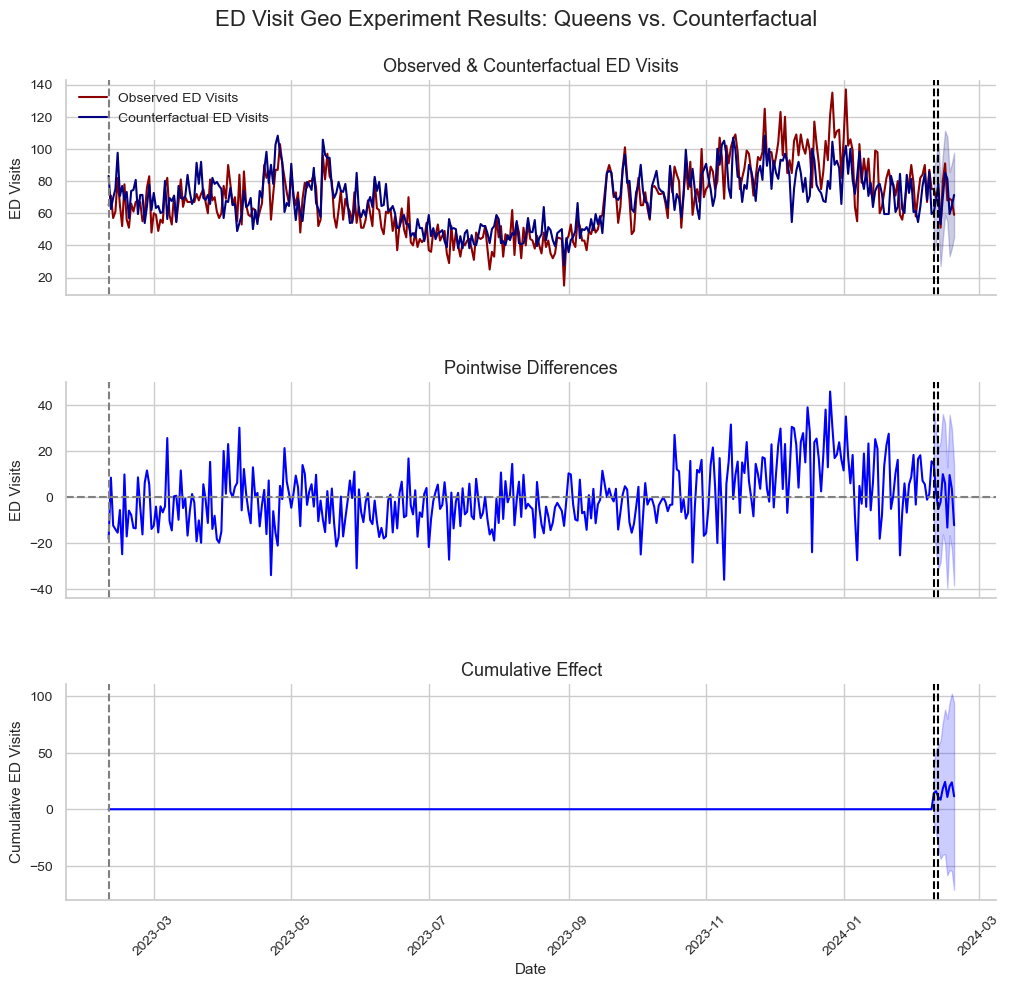

In [94]:
# Apply consistent global style
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.autolayout': False
})

# Create 3-panel figure
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Panel 1: Observed vs. Counterfactual ED Visits
axs[0].plot(data_final.index, data_final['queens_ed'], label='Observed ED Visits', color='darkred')
axs[0].plot(data_final.index, data_final['predicted_queens_ed'], label='Counterfactual ED Visits', color='navy')
axs[0].fill_between(data_final.index, data_final['cf_lower_ed'], data_final['cf_upper_ed'], color='navy', alpha=0.2)
axs[0].set_ylabel('ED Visits')
axs[0].set_title('Observed & Counterfactual ED Visits')
axs[0].legend(loc='upper left', frameon=False)

# Panel 2: Pointwise Differences
axs[1].plot(data_final.index, data_final['effect_ed'], label='Pointwise Difference', color='blue')
axs[1].fill_between(data_final.index, data_final['lower_diff_ed'], data_final['upper_diff_ed'], color='blue', alpha=0.2)
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_ylabel('ED Visits')
axs[1].set_title('Pointwise Differences')

# Panel 3: Cumulative Effect
axs[2].plot(data_final.index, data_final['cumulative_effect_ed'], label='Cumulative Effect', color='blue')
axs[2].fill_between(data_final.index, data_final['lower_cum_ed'], data_final['upper_cum_ed'], color='blue', alpha=0.2)
axs[2].set_ylabel('Cumulative ED Visits')
axs[2].set_title('Cumulative Effect')
axs[2].set_xlabel('Date')

# Add vertical lines for experiment phases
pretest_start = pd.to_datetime('2023-02-09')
test_start = pd.to_datetime('2024-02-10')
test_end = pd.to_datetime('2024-02-12')

for ax in axs:
    ax.axvline(pretest_start, color='gray', linestyle='--')
    ax.axvline(test_start, color='black', linestyle='--')
    ax.axvline(test_end, color='black', linestyle='--')
    ax.tick_params(axis='x', rotation=45)

# Add master title and adjust spacing
fig.suptitle("ED Visit Geo Experiment Results: Queens vs. Counterfactual", fontsize=16, y=1.0)
fig.subplots_adjust(top=0.93, hspace=0.4)

plt.show()


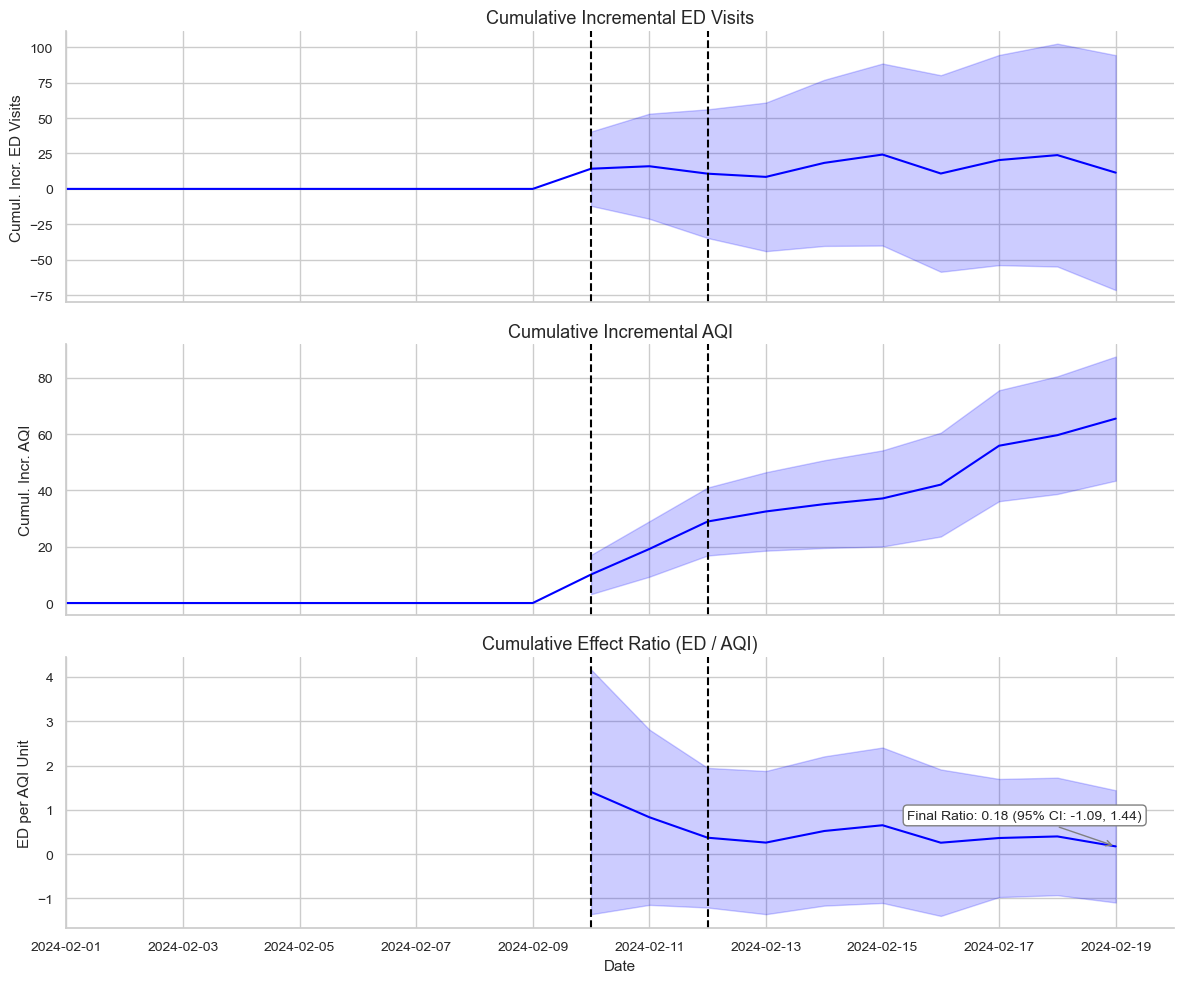

In [81]:
# Combine cumulative effects to get ed visits per AQI unit ratio 

# Get cumulative effects 
cum_ed = data_final['cumulative_effect_ed']
cum_aqi = data_final['cumulative_effect_aqi']

# Calculate ratio, avoid divide by 0 issues 
ratio = np.where(cum_aqi != 0, cum_ed / cum_aqi, np.nan)
data_final['effect_ratio'] = ratio

# Compute uncertainty of ratio 
std_ed = (pre['queens_ed'] - pre['predicted_queens_ed']).std()
std_aqi = (pre['queens_aqi'] - pre['predicted_queens_aqi']).std()

n_post_days = np.arange(len(data_final))
n_post_days[data_final.index < '2024-02-10'] = 0
n_post_days[data_final.index >= '2024-02-10'] = np.arange(1, sum(data_final.index >= '2024-02-10') + 1)

var_ed = (1.96 * std_ed * np.sqrt(n_post_days)) ** 2
var_aqi = (1.96 * std_aqi * np.sqrt(n_post_days)) ** 2

with np.errstate(divide='ignore', invalid='ignore'):
    std_ratio = np.sqrt((var_ed / cum_aqi**2) + ((cum_ed**2 * var_aqi) / cum_aqi**4))
    upper_ratio = ratio + std_ratio
    lower_ratio = ratio - std_ratio

data_final['upper_ratio'] = upper_ratio
data_final['lower_ratio'] = lower_ratio

# Plotting
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Panel 1: Cumulative incremental ED
axs[0].plot(data_final.index, cum_ed, color='blue')
axs[0].fill_between(data_final.index, data_final['lower_cum_ed'], data_final['upper_cum_ed'], color='blue', alpha=0.2)
axs[0].set_ylabel('Cumul. Incr. ED Visits')
axs[0].set_title('Cumulative Incremental ED Visits')

# Panel 2: Cumulative incremental AQI
axs[1].plot(data_final.index, cum_aqi, color='blue')
axs[1].fill_between(data_final.index, data_final['lower_cum_aqi'], data_final['upper_cum_aqi'], color='blue', alpha=0.2)
axs[1].set_ylabel('Cumul. Incr. AQI')
axs[1].set_title('Cumulative Incremental AQI')

# Panel 3: Ratio (ED per AQI unit)
axs[2].plot(data_final.index, data_final['effect_ratio'], color='blue')
axs[2].fill_between(data_final.index, data_final['lower_ratio'], data_final['upper_ratio'], color='blue', alpha=0.2)
axs[2].set_ylabel('ED per AQI Unit')
axs[2].set_title('Cumulative Effect Ratio (ED / AQI)')
axs[2].set_xlabel('Date')

pretest_start = pd.to_datetime('2023-02-09')
test_start = pd.to_datetime('2024-02-10')
test_end = pd.to_datetime('2024-02-12')

for ax in axs:
    ax.axvline(pretest_start, color='gray', linestyle='--')
    ax.axvline(test_start, color='black', linestyle='--')
    ax.axvline(test_end, color='black', linestyle='--')

# Limit x-axis to experiment window
x_start = pd.to_datetime('2024-02-01')
x_end = pd.to_datetime('2024-02-20')
for ax in axs:
    ax.set_xlim([x_start, x_end])

# Annotate final ratio on the bottom panel
valid_ratios = data_final.loc[post_mask & data_final['effect_ratio'].notna()]
final_date = valid_ratios.index[-1]

final_ratio = valid_ratios['effect_ratio'].iloc[-1]
ci_low = valid_ratios['lower_ratio'].iloc[-1]
ci_high = valid_ratios['upper_ratio'].iloc[-1]

annotation_text = f"Final Ratio: {final_ratio:.2f} (95% CI: {ci_low:.2f}, {ci_high:.2f})"

axs[2].annotate(
    annotation_text,
    xy=(final_date, final_ratio),
    xytext=(-150, 20),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='gray'),
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'),
    fontsize=10
)

plt.tight_layout()
plt.show()